In [1]:
#!/usr/bin/env python3
"""
WESAD Dataset Processing - Cell 1: Library Installation and Imports
Big Data Analytics (BDA) - IIIT Allahabad
Assignment: HDA-3 Multimodal Sleep EEG and Wearable Data Analysis
Phase 2: WESAD (Wearable Stress and Affect Detection) Analysis

Dataset: WESAD - 15 subjects, multimodal stress detection
Sensors: Chest (RespiBAN) + Wrist (Empatica E4)
Conditions: Baseline, Stress, Amusement, Meditation

Author: [Your Name]
Date: August 17, 2025
"""

# =============================================================================
# LIBRARY INSTALLATION
# =============================================================================

from tqdm import tqdm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt, find_peaks
from scipy import signal, stats
import warnings
from datetime import datetime
from pathlib import Path
import glob
import json
import os
import zipfile
import pickle
import numpy as np
import pandas as pd
import sys
import subprocess
print("🔧 Installing required libraries for WESAD processing...")
print("=" * 60)

# Core data processing libraries


def install_package(package_name):
    """Install package if not already installed"""
    try:
        __import__(package_name)
        print(f"✅ {package_name} already installed")
    except ImportError:
        print(f"📦 Installing {package_name}...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package_name])
        print(f"✅ {package_name} installed successfully")


# Install required packages
packages = [
    'pandas',
    'numpy',
    'scipy',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'plotly',
    'tqdm',
    'openpyxl',
    'xlrd',
    'pickle5',
    'zipfile36'  # For handling zip files
]

for package in packages:
    install_package(package)

print("\n🎉 All required libraries installed successfully!")
print("=" * 60)

# =============================================================================
# CORE IMPORTS
# =============================================================================

print("\n📚 Importing core libraries...")

# Core data processing

# Scientific computing

# Visualization

# Progress tracking

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')  # Clean plotting style
sns.set_palette("husl")

print("✅ All imports successful!")

# =============================================================================
# SYSTEM INFORMATION
# =============================================================================

print(f"\n🖥️ System Information:")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Current working directory: {os.getcwd()}")

print(f"\n📊 Ready to begin WESAD dataset processing!")
print("=" * 60)

🔧 Installing required libraries for WESAD processing...
✅ pandas already installed
✅ numpy already installed
✅ scipy already installed
📦 Installing scikit-learn...
✅ scikit-learn installed successfully
✅ matplotlib already installed
✅ seaborn already installed
✅ plotly already installed
✅ tqdm already installed
✅ openpyxl already installed
✅ xlrd already installed
✅ pickle5 already installed
✅ zipfile36 already installed

🎉 All required libraries installed successfully!

📚 Importing core libraries...
✅ All imports successful!

🖥️ System Information:
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 18:02:02) 
[Clang 18.1.8 ]
Pandas version: 2.3.1
NumPy version: 2.0.2
Current working directory: /Users/rishabh/Documents/BDA-course/HDA3/notebooks

📊 Ready to begin WESAD dataset processing!


In [2]:
#!/usr/bin/env python3
"""
WESAD Dataset Processing - Cell 2: Directory Setup and Configuration
"""

# =============================================================================
# DIRECTORY STRUCTURE SETUP
# =============================================================================

print("📁 Setting up WESAD directory structure...")
print("=" * 50)

# Base paths
BASE_DIR = Path.cwd().parent  # Go up from notebooks/ to project root
DATASETS_DIR = BASE_DIR / "datasets"
WESAD_RAW = DATASETS_DIR / "WESAD"
RESULTS_DIR = BASE_DIR / "results" / "wesad"
NOTEBOOKS_DIR = BASE_DIR / "notebooks"

# WESAD specific paths
WESAD_FEATURES = RESULTS_DIR / "features"
WESAD_MODELS = RESULTS_DIR / "models"
WESAD_VISUALIZATIONS = RESULTS_DIR / "visualizations"
WESAD_REPORTS = RESULTS_DIR / "reports"

# Create directories if they don't exist
directories = [
    DATASETS_DIR,
    WESAD_RAW,
    RESULTS_DIR,
    WESAD_FEATURES,
    WESAD_MODELS,
    WESAD_VISUALIZATIONS,
    WESAD_REPORTS
]

for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✅ {directory}")

print(f"\n📊 Directory structure created successfully!")

# =============================================================================
# WESAD DATASET CONFIGURATION
# =============================================================================

print(f"\n🔧 WESAD Dataset Configuration:")
print("=" * 40)

# WESAD Dataset Constants
CONFIG = {
    # Dataset Information
    'dataset_name': 'WESAD',
    'dataset_version': '1.0',
    'total_subjects': 15,  # S2-S17 (S1, S12 missing due to malfunction)
    'available_subjects': [f'S{i}' for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]],

    # Study Protocol
    'conditions': {
        0: 'Transient',      # Not defined/transition periods
        1: 'Baseline',       # Baseline condition
        2: 'Stress',         # TSST (Trier Social Stress Test)
        3: 'Amusement',      # Funny movie clips
        4: 'Meditation'      # Meditation/relaxation
        # 5,6,7: Ignore (reading tasks not relevant)
    },

    'condition_names': ['Transient', 'Baseline', 'Stress', 'Amusement', 'Meditation'],
    'target_conditions': [1, 2, 3, 4],  # Exclude transient periods

    # RespiBAN (Chest) Sensor Configuration
    'respiban': {
        'sampling_rate': 700,  # Hz
        'channels': {
            'ECG': {'unit': 'mV', 'description': 'Electrocardiogram'},
            'EDA': {'unit': 'μS', 'description': 'Electrodermal Activity'},
            'EMG': {'unit': 'mV', 'description': 'Electromyogram'},
            'TEMP': {'unit': '°C', 'description': 'Temperature'},
            'RESP': {'unit': '%', 'description': 'Respiration'},
            'ACC_X': {'unit': 'g', 'description': 'Accelerometer X-axis'},
            'ACC_Y': {'unit': 'g', 'description': 'Accelerometer Y-axis'},
            'ACC_Z': {'unit': 'g', 'description': 'Accelerometer Z-axis'}
        }
    },

    # Empatica E4 (Wrist) Sensor Configuration
    'e4': {
        'channels': {
            'ACC': {'sampling_rate': 32, 'unit': '1/64g', 'description': '3-axis Accelerometer'},
            'BVP': {'sampling_rate': 64, 'unit': 'nA', 'description': 'Blood Volume Pulse (PPG)'},
            'EDA': {'sampling_rate': 4, 'unit': 'μS', 'description': 'Electrodermal Activity'},
            'TEMP': {'sampling_rate': 4, 'unit': '°C', 'description': 'Temperature'}
        }
    },

    # Feature Extraction Parameters
    'feature_extraction': {
        'window_size': 60,        # seconds for windowing
        'overlap': 0.5,           # 50% overlap between windows
        'min_condition_duration': 30,  # minimum seconds per condition
        'filter_artifacts': True,
        'normalize_features': True
    },

    # File patterns
    'file_patterns': {
        'pkl_file': '{subject}.pkl',           # Synchronized data
        'quest_file': '{subject}_quest.csv',   # Questionnaires/protocol
        'readme_file': '{subject}_readme.txt',  # Subject info
        'respiban_file': '{subject}_respiban.txt',  # Raw chest data
        'e4_zip': '{subject}_E4_Data.zip'     # Raw wrist data
    }
}

# Feature categories for organization
FEATURE_CATEGORIES = {
    'heart_based': ['hr_mean', 'hr_std', 'hrv_rmssd', 'hrv_sdnn', 'hrv_pnn50'],
    'eda_features': ['eda_mean', 'eda_std', 'eda_peaks', 'eda_scr_count'],
    'movement': ['acc_mean', 'acc_std', 'acc_energy', 'movement_intensity'],
    'temperature': ['temp_mean', 'temp_std', 'temp_gradient'],
    'respiration': ['resp_rate', 'resp_depth', 'resp_variability'],
    'emg_features': ['emg_mean', 'emg_std', 'emg_energy'],
    'statistical': ['signal_quality', 'artifact_ratio', 'missing_ratio'],
    'multimodal': ['chest_wrist_correlation', 'sensor_agreement']
}

print(f"📊 Total subjects available: {len(CONFIG['available_subjects'])}")
# Exclude transient
print(f"🎯 Study conditions: {list(CONFIG['conditions'].values())[1:]}")
print(
    f"📡 Chest sensor sampling rate: {CONFIG['respiban']['sampling_rate']} Hz")
print(f"⌚ Wrist sensor channels: {len(CONFIG['e4']['channels'])}")
print(
    f"🪟 Feature extraction window: {CONFIG['feature_extraction']['window_size']}s")

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================


def get_subject_path(subject_id):
    """Get path to subject's folder"""
    return WESAD_RAW / subject_id


def get_subject_files(subject_id):
    """Get dictionary of expected files for a subject"""
    subject_path = get_subject_path(subject_id)
    files = {}

    for file_type, pattern in CONFIG['file_patterns'].items():
        file_path = subject_path / pattern.format(subject=subject_id)
        files[file_type] = file_path

    return files


def check_subject_data_availability():
    """Check which subjects have complete data available"""
    print(f"\n🔍 Checking WESAD data availability...")
    print("=" * 45)

    available_data = []
    missing_data = []

    for subject_id in CONFIG['available_subjects']:
        subject_files = get_subject_files(subject_id)

        # Check for essential files (pkl file is most important)
        pkl_exists = subject_files['pkl_file'].exists()
        quest_exists = subject_files['quest_file'].exists()

        if pkl_exists:
            available_data.append(subject_id)
            status = "✅"
        else:
            missing_data.append(subject_id)
            status = "❌"

        print(f"{status} {subject_id}: PKL={pkl_exists}, QUEST={quest_exists}")

    print(f"\n📈 Data Summary:")
    print(
        f"  Available subjects: {len(available_data)} / {len(CONFIG['available_subjects'])}")
    print(f"  Available: {available_data}")
    if missing_data:
        print(f"  Missing: {missing_data}")

    return available_data, missing_data


# Check data availability
available_subjects, missing_subjects = check_subject_data_availability()

# Update config with actually available subjects
CONFIG['actually_available'] = available_subjects
CONFIG['missing_subjects'] = missing_subjects

print(f"\n✅ WESAD configuration complete!")
print(f"📁 Ready to process {len(available_subjects)} subjects")
print("=" * 50)

📁 Setting up WESAD directory structure...
✅ /Users/rishabh/Documents/BDA-course/HDA3/datasets
✅ /Users/rishabh/Documents/BDA-course/HDA3/datasets/WESAD
✅ /Users/rishabh/Documents/BDA-course/HDA3/results/wesad
✅ /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/features
✅ /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/models
✅ /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/visualizations
✅ /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/reports

📊 Directory structure created successfully!

🔧 WESAD Dataset Configuration:
📊 Total subjects available: 15
🎯 Study conditions: ['Baseline', 'Stress', 'Amusement', 'Meditation']
📡 Chest sensor sampling rate: 700 Hz
⌚ Wrist sensor channels: 4
🪟 Feature extraction window: 60s

🔍 Checking WESAD data availability...
✅ S2: PKL=True, QUEST=True
✅ S3: PKL=True, QUEST=True
✅ S4: PKL=True, QUEST=True
✅ S5: PKL=True, QUEST=True
✅ S6: PKL=True, QUEST=True
✅ S7: PKL=True, QUEST=True
✅ S8: PKL=True, QUEST=True
✅ S9: PKL=True, QUEST

🔍 WESAD Complete Data Exploration
📊 Selected subject for exploration: S2

📁 Files for S2:
  ✅ pkl_file: S2.pkl (929.9 MB)
  ✅ quest_file: S2_quest.csv (0.0 MB)
  ✅ readme_file: S2_readme.txt (0.0 MB)
  ✅ respiban_file: S2_respiban.txt (249.2 MB)
  ✅ e4_zip: S2_E4_Data.zip (1.8 MB)

🔄 Loading synchronized data for S2...
✅ Synchronized data loaded successfully!

📊 Data Structure:
  Keys: ['signal', 'label', 'subject']
  Subject ID: S2

📡 Signal Data Structure:
  Devices: ['chest', 'wrist']

🫁 Chest (RespiBAN) Data:
  ACC: (4255300, 3) samples
  ECG: (4255300, 1) samples
  EMG: (4255300, 1) samples
  EDA: (4255300, 1) samples
  Temp: (4255300, 1) samples
  Resp: (4255300, 1) samples

⌚ Wrist (E4) Data:
  ACC: (194528, 3) samples
  BVP: (389056, 1) samples
  EDA: (24316, 1) samples
  TEMP: (24316, 1) samples

🏷️ Labels: (4255300,) samples
  Unique conditions: [0 1 2 3 4 6 7]
    0 (Transient): 2142701 samples (50.4%)
    1 (Baseline): 800800 samples (18.8%)
    2 (Stress): 430500 samples (

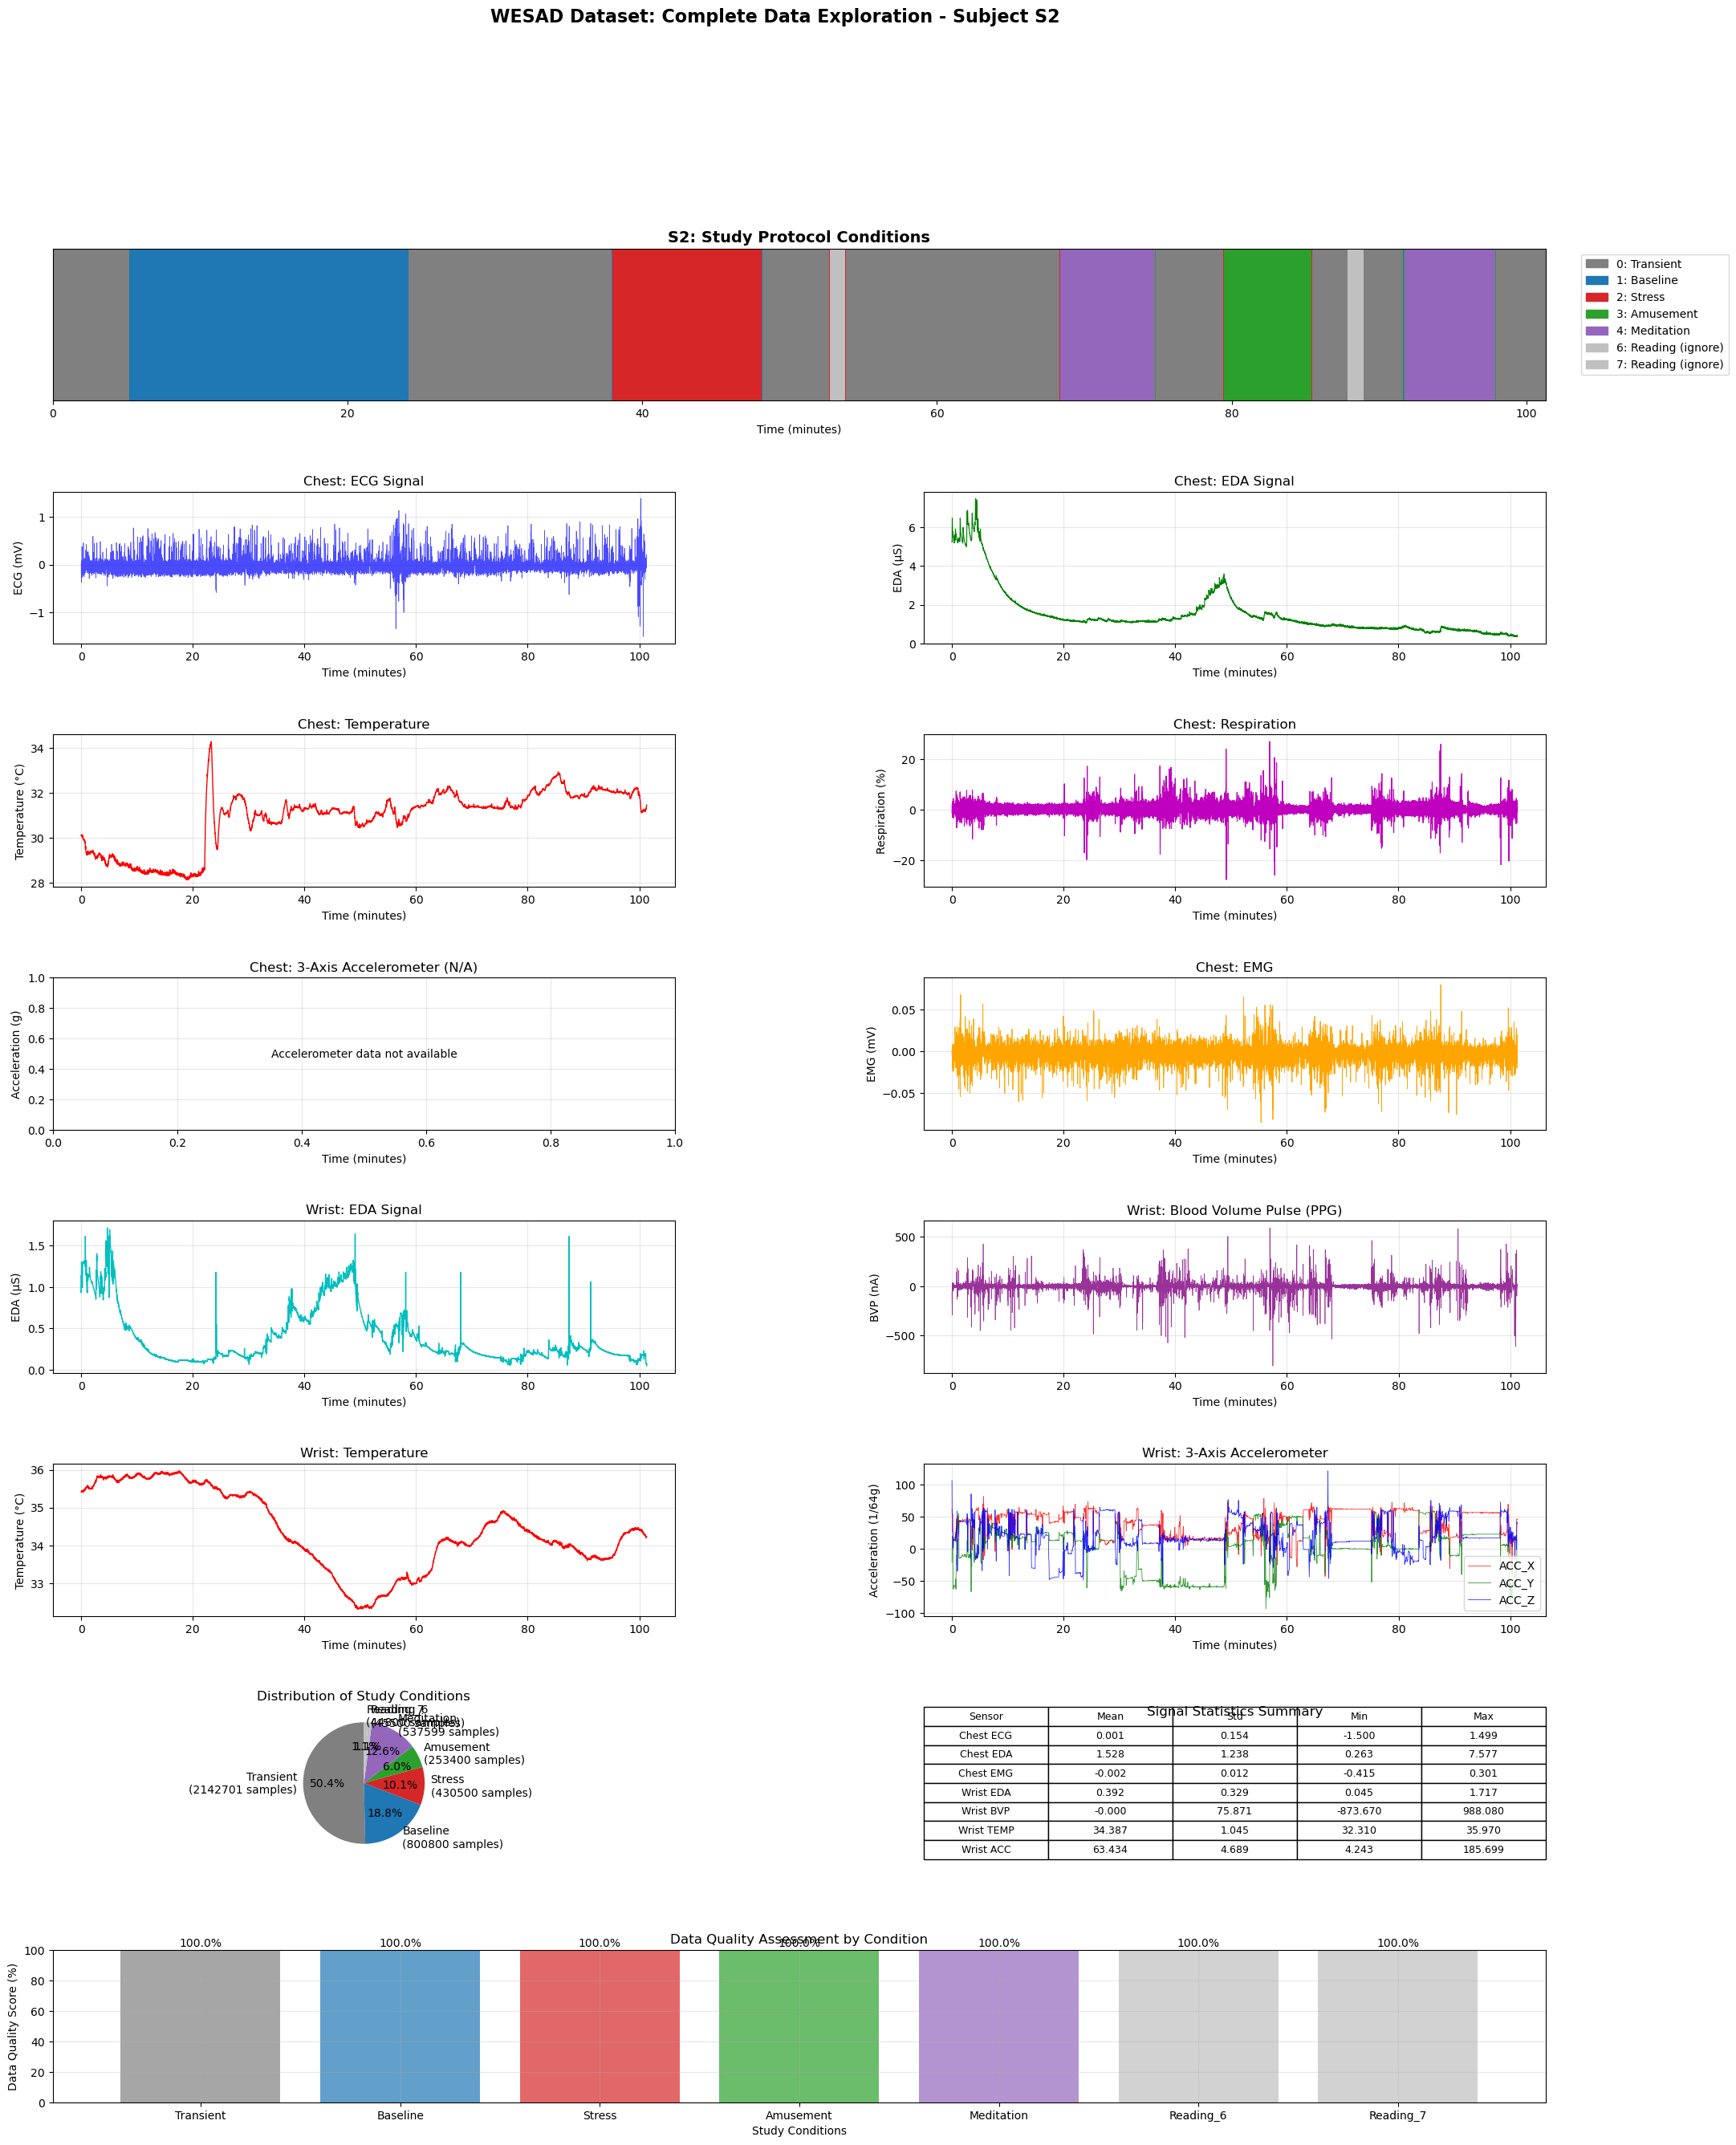


📊 Complete Data Exploration Summary for S2:
📏 Duration: 101.3 minutes (1.7 hours)
📡 Total sensors: 10
🫁 Chest sensors: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
⌚ Wrist sensors: ['ACC', 'BVP', 'EDA', 'TEMP']
🏷️ Conditions present: ['Transient', 'Baseline', 'Stress', 'Amusement', 'Meditation', 'Reading_6 (ignore)', 'Reading_7 (ignore)']
📈 Data quality: 100.0% average across conditions
💾 Visualization saved as: S2_complete_data_exploration.png

✅ Complete data exploration finished!
🎯 Ready to proceed with feature extraction for all subjects


In [3]:
#!/usr/bin/env python3
"""
WESAD Dataset Processing - Cell 3: Complete Data Exploration and Visualization
Comprehensive examination of one subject's complete data across all files
"""

# =============================================================================
# SELECT SUBJECT FOR DETAILED EXPLORATION
# =============================================================================

from matplotlib.colors import ListedColormap
print("🔍 WESAD Complete Data Exploration")
print("=" * 50)

# Select first available subject for detailed exploration
if available_subjects:
    exploration_subject = available_subjects[0]  # Usually S2
    print(f"📊 Selected subject for exploration: {exploration_subject}")
else:
    print("❌ No subjects available! Please check WESAD data directory.")
    raise FileNotFoundError("WESAD data not found")

subject_files = get_subject_files(exploration_subject)
print(f"\n📁 Files for {exploration_subject}:")
for file_type, file_path in subject_files.items():
    exists = "✅" if file_path.exists() else "❌"
    size = f"({file_path.stat().st_size / (1024*1024):.1f} MB)" if file_path.exists() else ""
    print(f"  {exists} {file_type}: {file_path.name} {size}")

# =============================================================================
# LOAD SYNCHRONIZED DATA (MAIN PKL FILE)
# =============================================================================

print(f"\n🔄 Loading synchronized data for {exploration_subject}...")

# Load the main synchronized data file
pkl_file = subject_files['pkl_file']
try:
    with open(pkl_file, 'rb') as f:
        wesad_data = pickle.load(f, encoding='latin1')

    print("✅ Synchronized data loaded successfully!")

    # Examine data structure
    print(f"\n📊 Data Structure:")
    print(f"  Keys: {list(wesad_data.keys())}")
    print(f"  Subject ID: {wesad_data.get('subject', 'N/A')}")

    # Signal data structure
    signal_data = wesad_data['signal']
    print(f"\n📡 Signal Data Structure:")
    print(f"  Devices: {list(signal_data.keys())}")

    # Chest sensor data
    chest_data = signal_data['chest']
    print(f"\n🫁 Chest (RespiBAN) Data:")
    for sensor, data in chest_data.items():
        print(f"  {sensor}: {np.array(data).shape} samples")

    # Wrist sensor data
    wrist_data = signal_data['wrist']
    print(f"\n⌚ Wrist (E4) Data:")
    for sensor, data in wrist_data.items():
        print(f"  {sensor}: {np.array(data).shape} samples")

    # Labels
    labels = np.array(wesad_data['label'])
    print(f"\n🏷️ Labels: {labels.shape} samples")
    unique_labels = np.unique(labels)
    print(f"  Unique conditions: {unique_labels}")
    for label in unique_labels:
        count = np.sum(labels == label)
        condition_name = CONFIG['conditions'].get(label, f'Unknown_{label}')
        print(
            f"    {label} ({condition_name}): {count} samples ({count/len(labels)*100:.1f}%)")

except Exception as e:
    print(f"❌ Error loading synchronized data: {e}")
    raise

# =============================================================================
# LOAD QUESTIONNAIRE AND PROTOCOL DATA
# =============================================================================

print(f"\n📋 Loading questionnaire and protocol data...")

quest_file = subject_files['quest_file']
try:
    # Read questionnaire file
    quest_data = pd.read_csv(quest_file, header=None)
    print("✅ Questionnaire data loaded!")
    print(f"  Shape: {quest_data.shape}")

    # Extract protocol timing (lines 3-4 contain start/end times)
    if quest_data.shape[0] >= 4:
        # Line 2: condition order
        protocol_order = quest_data.iloc[1].dropna().values
        start_times = quest_data.iloc[2].dropna(
        ).values     # Line 3: start times
        end_times = quest_data.iloc[3].dropna(
        ).values       # Line 4: end times

        print(f"\n⏱️ Protocol Timing:")
        for i, (condition, start, end) in enumerate(zip(protocol_order, start_times, end_times)):
            if condition not in ['bRead', 'fRead', 'sRead']:  # Ignore reading tasks
                duration = float(end) - float(start)
                print(f"  {condition}: {start} - {end} min ({duration:.1f} min)")

except Exception as e:
    print(f"⚠️ Could not load questionnaire data: {e}")

# =============================================================================
# DATA PREPARATION FOR VISUALIZATION
# =============================================================================

print(f"\n🔄 Preparing data for visualization...")

# Create time arrays
sampling_rate = CONFIG['respiban']['sampling_rate']
n_samples = len(labels)
time_seconds = np.arange(n_samples) / sampling_rate
duration_minutes = time_seconds[-1] / 60

print(f"📊 Dataset Overview:")
print(
    f"  Duration: {duration_minutes:.1f} minutes ({duration_minutes/60:.1f} hours)")
print(f"  Sampling rate: {sampling_rate} Hz")
print(f"  Total samples: {n_samples:,}")

# Convert chest data to numpy arrays
chest_signals = {}
for sensor_name, sensor_data in chest_data.items():
    chest_signals[sensor_name] = np.array(sensor_data)

# Convert wrist data to numpy arrays (note: different sampling rates)
wrist_signals = {}
for sensor_name, sensor_data in wrist_data.items():
    wrist_signals[sensor_name] = np.array(sensor_data)

# Debug: Show available sensors
print(f"🔍 Available chest sensors: {list(chest_signals.keys())}")
print(f"🔍 Available wrist sensors: {list(wrist_signals.keys())}")

# Create sensor name mapping (handle different naming conventions)


def get_sensor_data(signals_dict, preferred_names):
    """Get sensor data, trying multiple possible names"""
    for name in preferred_names:
        if name in signals_dict:
            return signals_dict[name]
    return None


# Set up common variables for plotting
# Use first available signal to determine downsample factor
first_signal = None
for signal in chest_signals.values():
    if signal is not None:
        first_signal = signal
        break

if first_signal is not None:
    # Downsample for plotting
    downsample_factor = max(1, len(first_signal) // 10000)
    time_down = time_seconds[::downsample_factor]
else:
    downsample_factor = 1
    time_down = time_seconds

# =============================================================================
# COMPREHENSIVE VISUALIZATIONS
# =============================================================================

print(f"\n📈 Creating comprehensive visualizations...")

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(24, 30))  # Increased figure size
# Increased spacing significantly
gs = fig.add_gridspec(8, 2, hspace=0.6, wspace=0.4)

# Color mapping for conditions (including ignored labels for visualization)
condition_colors = {
    0: '#808080',    # Transient (gray)
    1: '#1f77b4',    # Baseline (blue)
    2: '#d62728',    # Stress (red)
    3: '#2ca02c',    # Amusement (green)
    4: '#9467bd',    # Meditation (purple)
    5: '#c0c0c0',    # Reading task (light gray)
    6: '#c0c0c0',    # Reading task (light gray)
    7: '#c0c0c0'     # Reading task (light gray)
}

# 1. CONDITION LABELS OVERVIEW
ax1 = fig.add_subplot(gs[0, :])

# Create numeric condition blocks for imshow
condition_blocks_numeric = []
for i, label in enumerate(labels[::100]):  # Downsample for visibility
    condition_blocks_numeric.append(int(label))

# Create custom colormap
unique_conditions = sorted(list(set(condition_blocks_numeric)))
colors_list = [condition_colors.get(condition, '#c0c0c0')
               for condition in unique_conditions]
custom_cmap = ListedColormap(colors_list)

# Use imshow with numeric data
im = ax1.imshow([condition_blocks_numeric], aspect='auto',
                extent=[0, duration_minutes, 0, 1],
                cmap=custom_cmap, vmin=min(unique_conditions), vmax=max(unique_conditions))

ax1.set_xlabel('Time (minutes)')
ax1.set_title(f'{exploration_subject}: Study Protocol Conditions',
              fontsize=14, fontweight='bold')
ax1.set_yticks([])

# Add legend (only for conditions actually present in data)
legend_elements = []
for label in unique_labels:
    condition_name = CONFIG['conditions'].get(label, f'Reading/Other_{label}')
    if label in [1, 2, 3, 4]:  # Only show main conditions in legend
        color = condition_colors.get(label, '#c0c0c0')
        legend_elements.append(plt.Rectangle(
            (0, 0), 1, 1, color=color, label=f'{label}: {condition_name}'))
    elif label == 0:  # Show transient
        legend_elements.append(plt.Rectangle(
            (0, 0), 1, 1, color=condition_colors[0], label=f'{label}: Transient'))
    elif label in [5, 6, 7]:  # Show reading tasks
        legend_elements.append(plt.Rectangle(
            (0, 0), 1, 1, color='#c0c0c0', label=f'{label}: Reading (ignore)'))

ax1.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')

# 2. CHEST ECG SIGNAL
ax2 = fig.add_subplot(gs[1, 0])
ecg_signal = get_sensor_data(chest_signals, ['ECG', 'ecg'])
if ecg_signal is not None:
    ecg_down = ecg_signal[::downsample_factor]
    ax2.plot(time_down/60, ecg_down, 'b-', linewidth=0.5, alpha=0.7)
    ax2.set_title('Chest: ECG Signal')
else:
    ax2.text(0.5, 0.5, 'ECG data not available', ha='center',
             va='center', transform=ax2.transAxes)
    ax2.set_title('Chest: ECG Signal (N/A)')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('ECG (mV)')
ax2.grid(True, alpha=0.3)

# 3. CHEST EDA SIGNAL
ax3 = fig.add_subplot(gs[1, 1])
eda_signal = get_sensor_data(chest_signals, ['EDA', 'eda'])
if eda_signal is not None:
    eda_down = eda_signal[::downsample_factor]
    ax3.plot(time_down/60, eda_down, 'g-', linewidth=0.8)
    ax3.set_title('Chest: EDA Signal')
else:
    ax3.text(0.5, 0.5, 'EDA data not available', ha='center',
             va='center', transform=ax3.transAxes)
    ax3.set_title('Chest: EDA Signal (N/A)')
ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('EDA (μS)')
ax3.grid(True, alpha=0.3)

# 4. CHEST TEMPERATURE
ax4 = fig.add_subplot(gs[2, 0])
temp_signal = get_sensor_data(chest_signals, ['TEMP', 'temp', 'Temp'])
if temp_signal is not None:
    temp_down = temp_signal[::downsample_factor]
    ax4.plot(time_down/60, temp_down, 'r-', linewidth=1)
    ax4.set_title('Chest: Temperature')
else:
    ax4.text(0.5, 0.5, 'Temperature data not available',
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Chest: Temperature (N/A)')
ax4.set_xlabel('Time (minutes)')
ax4.set_ylabel('Temperature (°C)')
ax4.grid(True, alpha=0.3)

# 5. CHEST RESPIRATION
ax5 = fig.add_subplot(gs[2, 1])
resp_signal = get_sensor_data(chest_signals, ['RESP', 'resp', 'Resp'])
if resp_signal is not None:
    resp_down = resp_signal[::downsample_factor]
    ax5.plot(time_down/60, resp_down, 'm-', linewidth=0.8)
    ax5.set_title('Chest: Respiration')
else:
    ax5.text(0.5, 0.5, 'Respiration data not available',
             ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Chest: Respiration (N/A)')
ax5.set_xlabel('Time (minutes)')
ax5.set_ylabel('Respiration (%)')
ax5.grid(True, alpha=0.3)

# 6. CHEST ACCELEROMETER (3-axis)
ax6 = fig.add_subplot(gs[3, 0])
acc_x = get_sensor_data(chest_signals, ['ACC_X', 'acc_x', 'Acc_X'])
acc_y = get_sensor_data(chest_signals, ['ACC_Y', 'acc_y', 'Acc_Y'])
acc_z = get_sensor_data(chest_signals, ['ACC_Z', 'acc_z', 'Acc_Z'])

if acc_x is not None and acc_y is not None and acc_z is not None:
    for acc_signal, axis, color in zip([acc_x, acc_y, acc_z], ['X', 'Y', 'Z'], ['r', 'g', 'b']):
        acc_down = acc_signal[::downsample_factor]
        ax6.plot(time_down/60, acc_down, color=color,
                 label=f'ACC_{axis}', linewidth=0.6, alpha=0.8)
    ax6.legend()
    ax6.set_title('Chest: 3-Axis Accelerometer')
else:
    ax6.text(0.5, 0.5, 'Accelerometer data not available',
             ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Chest: 3-Axis Accelerometer (N/A)')
ax6.set_xlabel('Time (minutes)')
ax6.set_ylabel('Acceleration (g)')
ax6.grid(True, alpha=0.3)

# 7. CHEST EMG
ax7 = fig.add_subplot(gs[3, 1])
emg_signal = get_sensor_data(chest_signals, ['EMG', 'emg'])
if emg_signal is not None:
    emg_down = emg_signal[::downsample_factor]
    ax7.plot(time_down/60, emg_down, 'orange', linewidth=0.6)
    ax7.set_title('Chest: EMG')
else:
    ax7.text(0.5, 0.5, 'EMG data not available', ha='center',
             va='center', transform=ax7.transAxes)
    ax7.set_title('Chest: EMG (N/A)')
ax7.set_xlabel('Time (minutes)')
ax7.set_ylabel('EMG (mV)')
ax7.grid(True, alpha=0.3)

# 8. WRIST EDA COMPARISON
ax8 = fig.add_subplot(gs[4, 0])
wrist_eda = get_sensor_data(wrist_signals, ['EDA', 'eda'])
if wrist_eda is not None:
    wrist_time = np.arange(len(wrist_eda)) / 4.0  # 4Hz sampling
    ax8.plot(wrist_time/60, wrist_eda, 'c-',
             linewidth=1, label='Wrist EDA (4Hz)')
    ax8.set_title('Wrist: EDA Signal')
else:
    ax8.text(0.5, 0.5, 'Wrist EDA data not available',
             ha='center', va='center', transform=ax8.transAxes)
    ax8.set_title('Wrist: EDA Signal (N/A)')
ax8.set_xlabel('Time (minutes)')
ax8.set_ylabel('EDA (μS)')
ax8.grid(True, alpha=0.3)

# 9. WRIST BVP (Blood Volume Pulse)
ax9 = fig.add_subplot(gs[4, 1])
wrist_bvp = get_sensor_data(wrist_signals, ['BVP', 'bvp'])
if wrist_bvp is not None:
    bvp_time = np.arange(len(wrist_bvp)) / 64.0  # 64Hz sampling
    bvp_downsample = max(1, len(wrist_bvp) // 5000)
    bvp_time_down = bvp_time[::bvp_downsample]
    bvp_down = wrist_bvp[::bvp_downsample]
    ax9.plot(bvp_time_down/60, bvp_down, 'purple', linewidth=0.5, alpha=0.8)
    ax9.set_title('Wrist: Blood Volume Pulse (PPG)')
else:
    ax9.text(0.5, 0.5, 'BVP data not available', ha='center',
             va='center', transform=ax9.transAxes)
    ax9.set_title('Wrist: Blood Volume Pulse (N/A)')
ax9.set_xlabel('Time (minutes)')
ax9.set_ylabel('BVP (nA)')
ax9.grid(True, alpha=0.3)

# 10. WRIST TEMPERATURE
ax10 = fig.add_subplot(gs[5, 0])
wrist_temp = get_sensor_data(wrist_signals, ['TEMP', 'temp'])
if wrist_temp is not None:
    wrist_temp_time = np.arange(len(wrist_temp)) / 4.0  # 4Hz sampling
    ax10.plot(wrist_temp_time/60, wrist_temp, 'red', linewidth=1)
    ax10.set_title('Wrist: Temperature')
else:
    ax10.text(0.5, 0.5, 'Wrist temperature data not available',
              ha='center', va='center', transform=ax10.transAxes)
    ax10.set_title('Wrist: Temperature (N/A)')
ax10.set_xlabel('Time (minutes)')
ax10.set_ylabel('Temperature (°C)')
ax10.grid(True, alpha=0.3)

# 11. WRIST ACCELEROMETER
ax11 = fig.add_subplot(gs[5, 1])
wrist_acc = get_sensor_data(wrist_signals, ['ACC', 'acc'])
if wrist_acc is not None and len(wrist_acc.shape) == 2 and wrist_acc.shape[1] == 3:
    acc_time = np.arange(len(wrist_acc)) / 32.0  # 32Hz sampling
    acc_downsample = max(1, len(wrist_acc) // 2000)
    for i, (axis, color) in enumerate(zip(['X', 'Y', 'Z'], ['r', 'g', 'b'])):
        acc_axis = wrist_acc[::acc_downsample, i]
        acc_time_down = acc_time[::acc_downsample]
        ax11.plot(acc_time_down/60, acc_axis, color=color,
                  label=f'ACC_{axis}', linewidth=0.6, alpha=0.8)
    ax11.legend()
    ax11.set_title('Wrist: 3-Axis Accelerometer')
else:
    ax11.text(0.5, 0.5, 'Wrist accelerometer data not available',
              ha='center', va='center', transform=ax11.transAxes)
    ax11.set_title('Wrist: 3-Axis Accelerometer (N/A)')
ax11.set_xlabel('Time (minutes)')
ax11.set_ylabel('Acceleration (1/64g)')
ax11.grid(True, alpha=0.3)

# 12. CONDITION DISTRIBUTION PIE CHART
ax12 = fig.add_subplot(gs[6, 0])
condition_counts = [np.sum(labels == label) for label in unique_labels]
condition_labels = []
for label, count in zip(unique_labels, condition_counts):
    if label in CONFIG['conditions']:
        condition_name = CONFIG['conditions'][label]
    elif label in [5, 6, 7]:
        condition_name = f'Reading_{label}'
    else:
        condition_name = f'Unknown_{label}'
    condition_labels.append(f'{condition_name}\n({count} samples)')

condition_pie_colors = [condition_colors.get(
    label, '#lightgray') for label in unique_labels]

ax12.pie(condition_counts, labels=condition_labels, colors=condition_pie_colors,
         autopct='%1.1f%%', startangle=90)
ax12.set_title('Distribution of Study Conditions')

# 13. SIGNAL STATISTICS TABLE
ax13 = fig.add_subplot(gs[6, 1])
ax13.axis('off')

# Calculate statistics for chest sensors
stats_data = []
for sensor_name in ['ECG', 'EDA', 'TEMP', 'RESP', 'EMG', 'ACC_X', 'ACC_Y', 'ACC_Z']:
    signal = get_sensor_data(chest_signals, [sensor_name, sensor_name.lower()])
    if signal is not None:
        stats_data.append([
            f'Chest {sensor_name}',
            f'{np.mean(signal):.3f}',
            f'{np.std(signal):.3f}',
            f'{np.min(signal):.3f}',
            f'{np.max(signal):.3f}'
        ])

# Add wrist sensor stats
for sensor_name in ['EDA', 'BVP', 'TEMP']:
    signal = get_sensor_data(wrist_signals, [sensor_name, sensor_name.lower()])
    if signal is not None:
        stats_data.append([
            f'Wrist {sensor_name}',
            f'{np.mean(signal):.3f}',
            f'{np.std(signal):.3f}',
            f'{np.min(signal):.3f}',
            f'{np.max(signal):.3f}'
        ])

# Handle wrist accelerometer specially
wrist_acc = get_sensor_data(wrist_signals, ['ACC', 'acc'])
if wrist_acc is not None and len(wrist_acc.shape) == 2 and wrist_acc.shape[1] == 3:
    # For 3D accelerometer, calculate magnitude
    signal_mag = np.sqrt(np.sum(wrist_acc**2, axis=1))
    stats_data.append([
        f'Wrist ACC',
        f'{np.mean(signal_mag):.3f}',
        f'{np.std(signal_mag):.3f}',
        f'{np.min(signal_mag):.3f}',
        f'{np.max(signal_mag):.3f}'
    ])

# Create table only if we have data
if stats_data:
    table = ax13.table(cellText=stats_data,
                       colLabels=['Sensor', 'Mean', 'Std', 'Min', 'Max'],
                       cellLoc='center',
                       loc='center',
                       bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax13.set_title('Signal Statistics Summary', y=0.9)
else:
    ax13.text(0.5, 0.5, 'No sensor data available for statistics',
              ha='center', va='center', transform=ax13.transAxes)

# 14. DATA QUALITY ASSESSMENT
ax14 = fig.add_subplot(gs[7, :])

# Calculate missing data and artifacts for each condition
quality_metrics = {}
ecg_signal = get_sensor_data(
    chest_signals, ['ECG', 'ecg'])  # Use the robust getter
eda_signal = get_sensor_data(
    chest_signals, ['EDA', 'eda'])  # Use the robust getter

for condition in unique_labels:
    condition_mask = labels == condition
    condition_duration = np.sum(condition_mask) / sampling_rate / 60  # minutes

    # Simple artifact detection (values beyond reasonable physiological ranges)
    ecg_artifacts = 0
    eda_artifacts = 0

    if ecg_signal is not None:
        ecg_condition = ecg_signal[condition_mask]
        ecg_artifacts = np.sum((ecg_condition < -5) | (ecg_condition > 5))

    if eda_signal is not None:
        eda_condition = eda_signal[condition_mask]
        eda_artifacts = np.sum((eda_condition < 0) | (eda_condition > 100))

    total_artifacts = ecg_artifacts + eda_artifacts
    total_samples = np.sum(condition_mask)
    quality_score = 100 - (total_artifacts / total_samples *
                           100) if total_samples > 0 else 0

    quality_metrics[condition] = {
        'duration_min': condition_duration,
        'ecg_artifacts': ecg_artifacts,
        'eda_artifacts': eda_artifacts,
        'quality_score': quality_score
    }

# Plot quality metrics
conditions = list(quality_metrics.keys())
quality_scores = [quality_metrics[c]['quality_score'] for c in conditions]
condition_names = []
for c in conditions:
    if c in CONFIG['conditions']:
        condition_names.append(CONFIG['conditions'][c])
    elif c in [5, 6, 7]:
        condition_names.append(f'Reading_{c}')
    else:
        condition_names.append(f'Unknown_{c}')

bars = ax14.bar(range(len(conditions)), quality_scores,
                color=[condition_colors.get(c, '#c0c0c0') for c in conditions], alpha=0.7)

ax14.set_xlabel('Study Conditions')
ax14.set_ylabel('Data Quality Score (%)')
ax14.set_title('Data Quality Assessment by Condition')
ax14.set_xticks(range(len(conditions)))
ax14.set_xticklabels(condition_names)
ax14.set_ylim(0, 100)
ax14.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, quality_scores):
    height = bar.get_height()
    ax14.text(bar.get_x() + bar.get_width()/2., height + 1,
              f'{score:.1f}%', ha='center', va='bottom')

plt.suptitle(f'WESAD Dataset: Complete Data Exploration - Subject {exploration_subject}',
             fontsize=16, fontweight='bold', y=0.98)

# Save the comprehensive visualization
viz_file = WESAD_VISUALIZATIONS / \
    f'{exploration_subject}_complete_data_exploration.png'
plt.savefig(viz_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Comprehensive visualization saved: {viz_file}")

plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print(f"\n📊 Complete Data Exploration Summary for {exploration_subject}:")
print("=" * 60)
print(
    f"📏 Duration: {duration_minutes:.1f} minutes ({duration_minutes/60:.1f} hours)")
print(f"📡 Total sensors: {len(chest_signals) + len(wrist_signals)}")
print(f"🫁 Chest sensors: {list(chest_signals.keys())}")
print(f"⌚ Wrist sensors: {list(wrist_signals.keys())}")

# Show conditions present, handling reading tasks
conditions_present = []
for c in unique_labels:
    if c in CONFIG['conditions']:
        conditions_present.append(CONFIG['conditions'][c])
    elif c in [5, 6, 7]:
        conditions_present.append(f'Reading_{c} (ignore)')
    else:
        conditions_present.append(f'Unknown_{c}')

print(f"🏷️ Conditions present: {conditions_present}")
print(
    f"📈 Data quality: {np.mean(quality_scores):.1f}% average across conditions")
print(f"💾 Visualization saved as: {viz_file.name}")

print(f"\n✅ Complete data exploration finished!")
print(f"🎯 Ready to proceed with feature extraction for all subjects")
print("=" * 60)

📊 Creating WESAD Condition Distribution Pie Chart...
✅ Condition distribution saved: /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/visualizations/S2_condition_distribution.png


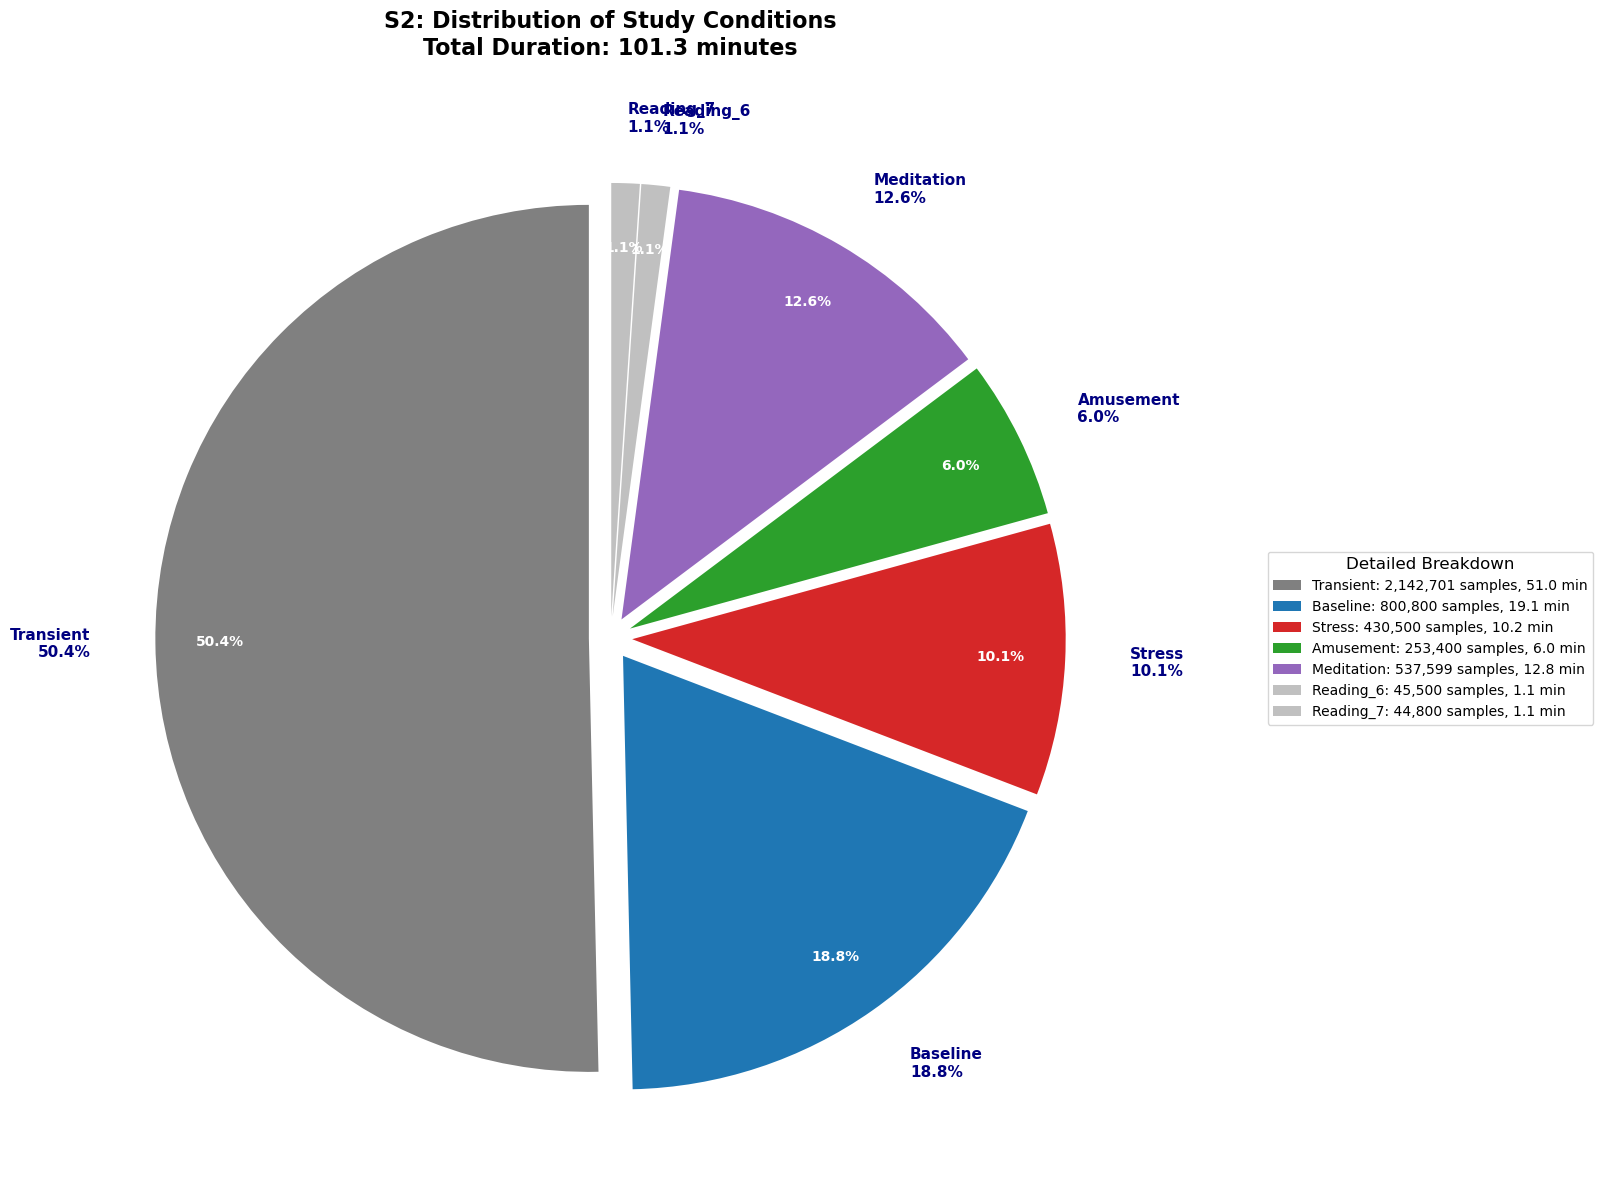


📊 Creating WESAD Signal Statistics and Quality Assessment...
✅ Statistics and quality assessment saved: /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/visualizations/S2_statistics_quality.png


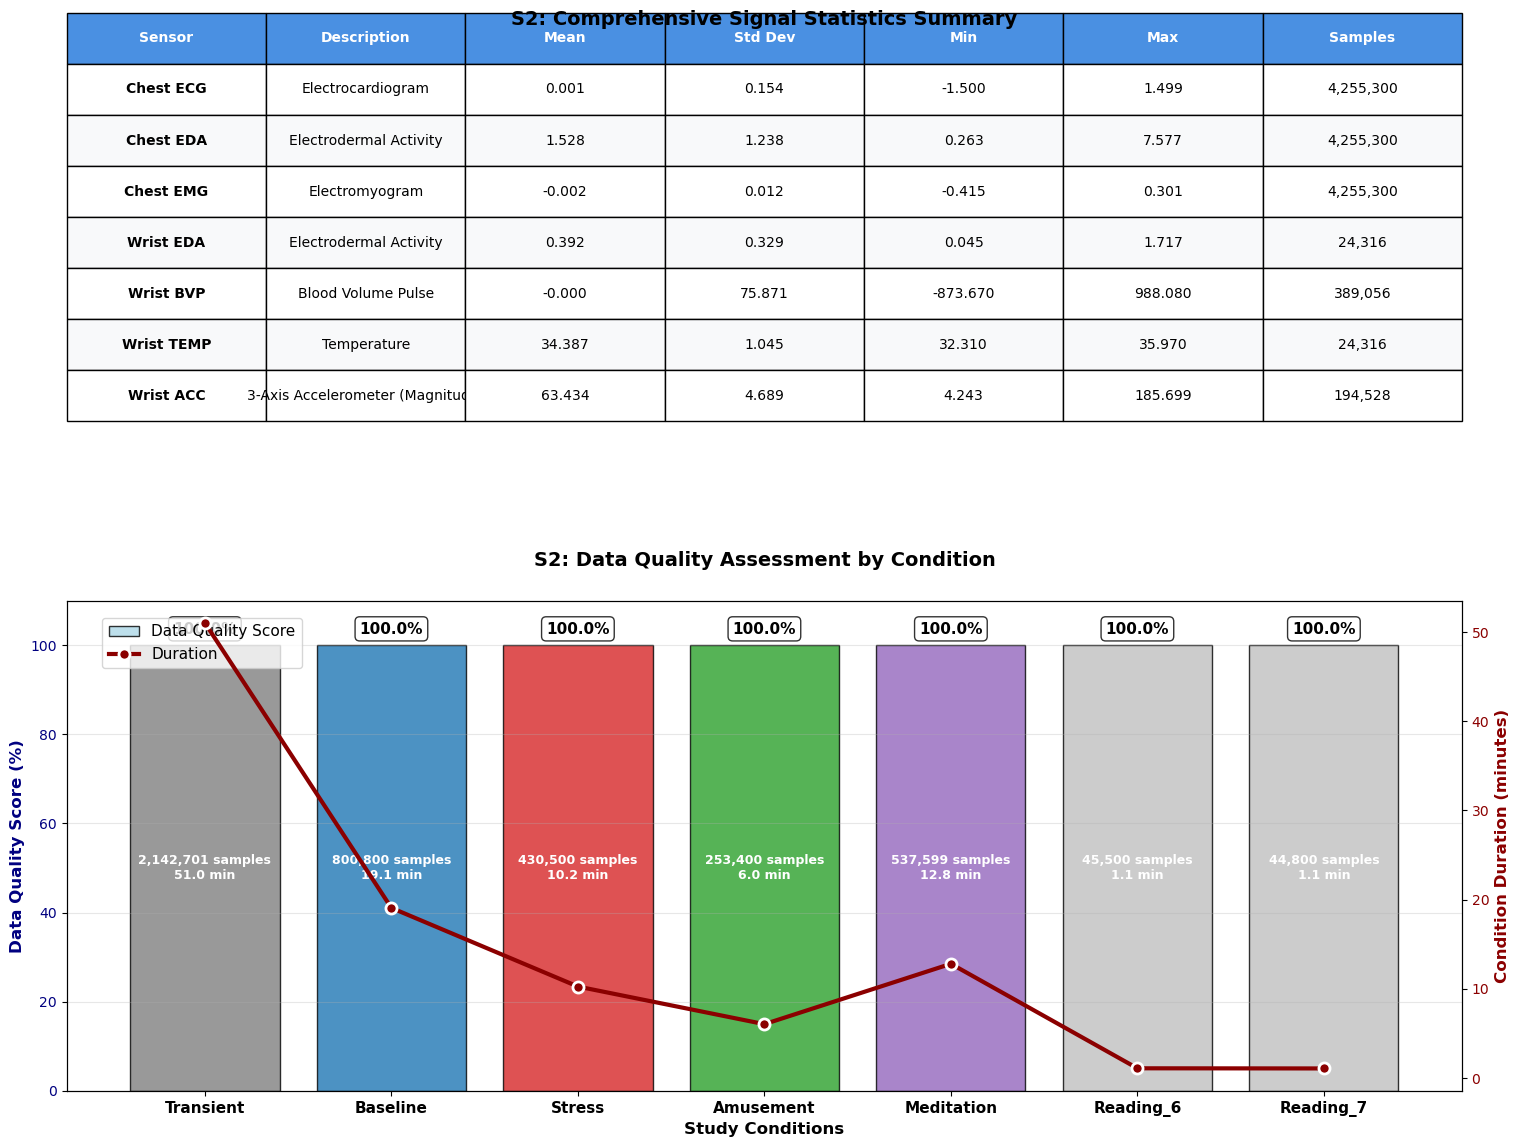


📈 WESAD Summary Statistics and Quality Insights for S2:
🕒 Total session duration: 101.3 minutes (1.7 hours)
📊 Average data quality: 100.0%
🎯 Conditions analyzed: 7
✅ Best quality condition: Transient (100.0%)
⚠️  Lowest quality condition: Transient (100.0%)
🫁 Chest sensors available: 3/5
⌚ Wrist sensors available: 4/4
📡 Total multimodal sensors: 7

✅ Summary statistics and quality assessment complete!
📁 Saved visualizations:
   1. S2_condition_distribution.png
   2. S2_statistics_quality.png


In [4]:
#!/usr/bin/env python3
"""
WESAD Dataset Processing - Cell 4: Summary Statistics and Quality Assessment
Split into two separate visualizations for better spacing and clarity
"""

# =============================================================================
# VISUALIZATION 1: CONDITION DISTRIBUTION PIE CHART
# =============================================================================

print("📊 Creating WESAD Condition Distribution Pie Chart...")
print("=" * 50)

# Create a large figure dedicated to the pie chart
fig1 = plt.figure(figsize=(16, 12))
ax1 = fig1.add_subplot(111)

condition_counts = [np.sum(labels == label) for label in unique_labels]
condition_labels = []
condition_details = []

for label, count in zip(unique_labels, condition_counts):
    if label in CONFIG['conditions']:
        condition_name = CONFIG['conditions'][label]
    elif label in [5, 6, 7]:
        condition_name = f'Reading_{label}'
    else:
        condition_name = f'Unknown_{label}'

    # Calculate percentage and duration
    percentage = (count / len(labels)) * 100
    duration_min = count / sampling_rate / 60

    # Short labels for the pie chart
    condition_labels.append(f'{condition_name}\n{percentage:.1f}%')

    # Detailed info for the legend
    condition_details.append(
        f'{condition_name}: {count:,} samples, {duration_min:.1f} min')

condition_pie_colors = [condition_colors.get(
    label, '#c0c0c0') for label in unique_labels]

# Create pie chart with larger text and better spacing
wedges, texts, autotexts = ax1.pie(condition_counts,
                                   labels=condition_labels,
                                   colors=condition_pie_colors,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   textprops={'fontsize': 12,
                                              'fontweight': 'bold'},
                                   pctdistance=0.85,  # Distance of percentage labels from center
                                   labeldistance=1.15,  # Distance of condition labels from center
                                   # Slight separation for clarity
                                   explode=[0.05] * len(unique_labels))

# Improve text placement and size
for text in texts:
    text.set_fontsize(11)
    text.set_weight('bold')
    text.set_color('navy')

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_weight('bold')
    autotext.set_color('white')

ax1.set_title(f'{exploration_subject}: Distribution of Study Conditions\nTotal Duration: {duration_minutes:.1f} minutes',
              fontsize=16, fontweight='bold', pad=30)

# Add detailed legend outside the pie chart
ax1.legend(wedges, condition_details,
           title="Detailed Breakdown",
           title_fontsize=12,
           fontsize=10,
           loc="center left",
           bbox_to_anchor=(1.1, 0, 0.5, 1))

plt.tight_layout()

# Save the pie chart
pie_viz_file = WESAD_VISUALIZATIONS / \
    f'{exploration_subject}_condition_distribution.png'
plt.savefig(pie_viz_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Condition distribution saved: {pie_viz_file}")

plt.show()

# =============================================================================
# VISUALIZATION 2: SIGNAL STATISTICS & QUALITY ASSESSMENT
# =============================================================================

print("\n📊 Creating WESAD Signal Statistics and Quality Assessment...")
print("=" * 55)

# Create a figure with two subplots arranged vertically
fig2 = plt.figure(figsize=(18, 14))
gs = fig2.add_gridspec(2, 1, hspace=0.4, height_ratios=[1, 1.2])

# =============================================================================
# 2A. SIGNAL STATISTICS SUMMARY TABLE
# =============================================================================

ax2 = fig2.add_subplot(gs[0])
ax2.axis('off')

# Calculate statistics for all available sensors
stats_data = []

# Define sensor display order and names
chest_sensors = [
    ('ECG', 'Electrocardiogram'),
    ('EDA', 'Electrodermal Activity'),
    ('TEMP', 'Temperature'),
    ('RESP', 'Respiration'),
    ('EMG', 'Electromyogram')
]

wrist_sensors = [
    ('EDA', 'Electrodermal Activity'),
    ('BVP', 'Blood Volume Pulse'),
    ('TEMP', 'Temperature'),
    ('ACC', '3-Axis Accelerometer')
]

# Process chest sensors
for sensor_code, sensor_name in chest_sensors:
    signal = get_sensor_data(chest_signals, [sensor_code, sensor_code.lower()])
    if signal is not None:
        stats_data.append([
            f'Chest {sensor_code}',
            sensor_name,
            f'{np.mean(signal):.3f}',
            f'{np.std(signal):.3f}',
            f'{np.min(signal):.3f}',
            f'{np.max(signal):.3f}',
            f'{len(signal):,}'
        ])

# Process wrist sensors
for sensor_code, sensor_name in wrist_sensors:
    signal = get_sensor_data(wrist_signals, [sensor_code, sensor_code.lower()])
    if signal is not None:
        if sensor_code == 'ACC' and len(signal.shape) == 2 and signal.shape[1] == 3:
            # For 3D accelerometer, calculate magnitude
            signal_mag = np.sqrt(np.sum(signal**2, axis=1))
            stats_data.append([
                f'Wrist {sensor_code}',
                f'{sensor_name} (Magnitude)',
                f'{np.mean(signal_mag):.3f}',
                f'{np.std(signal_mag):.3f}',
                f'{np.min(signal_mag):.3f}',
                f'{np.max(signal_mag):.3f}',
                f'{len(signal_mag):,}'
            ])
        else:
            stats_data.append([
                f'Wrist {sensor_code}',
                sensor_name,
                f'{np.mean(signal):.3f}',
                f'{np.std(signal):.3f}',
                f'{np.min(signal):.3f}',
                f'{np.max(signal):.3f}',
                f'{len(signal):,}'
            ])

# Create comprehensive statistics table
if stats_data:
    table = ax2.table(cellText=stats_data,
                      colLabels=['Sensor', 'Description', 'Mean',
                                 'Std Dev', 'Min', 'Max', 'Samples'],
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)

    # Color the header row
    for i in range(7):
        table[(0, i)].set_facecolor('#4A90E2')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors for better readability
    for i in range(1, len(stats_data) + 1):
        for j in range(7):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F8F9FA')
            else:
                table[(i, j)].set_facecolor('#FFFFFF')

            # Make sensor names bold
            if j == 0:  # Sensor column
                table[(i, j)].set_text_props(weight='bold')

    ax2.set_title(f'{exploration_subject}: Comprehensive Signal Statistics Summary',
                  fontsize=14, fontweight='bold', y=0.95)
else:
    ax2.text(0.5, 0.5, 'No sensor data available for statistics',
             ha='center', va='center', transform=ax2.transAxes, fontsize=14)

# =============================================================================
# 2B. DATA QUALITY ASSESSMENT BY CONDITION
# =============================================================================

ax3 = fig2.add_subplot(gs[1])

# Calculate comprehensive quality metrics for each condition
quality_metrics = {}
ecg_signal = get_sensor_data(chest_signals, ['ECG', 'ecg'])
eda_signal = get_sensor_data(chest_signals, ['EDA', 'eda'])

for condition in unique_labels:
    condition_mask = labels == condition
    condition_duration = np.sum(condition_mask) / sampling_rate / 60  # minutes

    # Initialize metrics
    ecg_artifacts = 0
    eda_artifacts = 0
    missing_data = 0

    # ECG quality assessment
    if ecg_signal is not None:
        ecg_condition = ecg_signal[condition_mask]
        ecg_artifacts = np.sum((ecg_condition < -5) | (ecg_condition > 5))
        missing_data += np.sum(np.isnan(ecg_condition)
                               ) if np.any(np.isnan(ecg_condition)) else 0

    # EDA quality assessment
    if eda_signal is not None:
        eda_condition = eda_signal[condition_mask]
        eda_artifacts = np.sum((eda_condition < 0) | (eda_condition > 100))
        missing_data += np.sum(np.isnan(eda_condition)
                               ) if np.any(np.isnan(eda_condition)) else 0

    total_artifacts = ecg_artifacts + eda_artifacts + missing_data
    total_samples = np.sum(condition_mask)
    quality_score = max(
        0, 100 - (total_artifacts / total_samples * 100)) if total_samples > 0 else 0

    quality_metrics[condition] = {
        'duration_min': condition_duration,
        'total_samples': total_samples,
        'ecg_artifacts': ecg_artifacts,
        'eda_artifacts': eda_artifacts,
        'missing_data': missing_data,
        'quality_score': quality_score
    }

# Create enhanced quality assessment plot
conditions = list(quality_metrics.keys())
quality_scores = [quality_metrics[c]['quality_score'] for c in conditions]
durations = [quality_metrics[c]['duration_min'] for c in conditions]

condition_names = []
for c in conditions:
    if c in CONFIG['conditions']:
        condition_names.append(CONFIG['conditions'][c])
    elif c in [5, 6, 7]:
        condition_names.append(f'Reading_{c}')
    else:
        condition_names.append(f'Unknown_{c}')

# Create bars with quality scores
bars = ax3.bar(range(len(conditions)), quality_scores,
               color=[condition_colors.get(c, '#c0c0c0') for c in conditions],
               alpha=0.8, edgecolor='black', linewidth=1)

# Add duration information as secondary y-axis
ax3_twin = ax3.twinx()
duration_line = ax3_twin.plot(range(len(conditions)), durations,
                              color='darkred', marker='o', linewidth=3,
                              markersize=8, label='Duration (min)', markeredgecolor='white', markeredgewidth=2)

# Enhanced formatting
ax3.set_xlabel('Study Conditions', fontsize=12, fontweight='bold')
ax3.set_ylabel('Data Quality Score (%)', fontsize=12,
               fontweight='bold', color='navy')
ax3_twin.set_ylabel('Condition Duration (minutes)',
                    fontsize=12, fontweight='bold', color='darkred')
ax3.set_title(f'{exploration_subject}: Data Quality Assessment by Condition',
              fontsize=14, fontweight='bold', pad=25)

ax3.set_xticks(range(len(conditions)))
ax3.set_xticklabels(condition_names, fontsize=11, fontweight='bold')
ax3.set_ylim(0, 110)
ax3.grid(True, alpha=0.3, axis='y')

# Color the y-axis labels and ticks
ax3.tick_params(axis='y', labelcolor='navy', labelsize=10)
ax3_twin.tick_params(axis='y', labelcolor='darkred', labelsize=10)

# Add enhanced value labels
for i, (bar, score, duration) in enumerate(zip(bars, quality_scores, durations)):
    height = bar.get_height()

    # Quality score on top of bar with better styling
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{score:.1f}%', ha='center', va='bottom',
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    # Sample count and duration inside bar
    samples = quality_metrics[conditions[i]]['total_samples']
    ax3.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{samples:,} samples\n{duration:.1f} min',
             ha='center', va='center', fontsize=9,
             color='white' if height > 50 else 'black',
             fontweight='bold')

# Add comprehensive legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', alpha=0.8,
                  edgecolor='black', label='Data Quality Score'),
    plt.Line2D([0], [0], color='darkred', linewidth=3, marker='o', markersize=8,
               markeredgecolor='white', markeredgewidth=2, label='Duration')
]
ax3.legend(handles=legend_elements, loc='upper left',
           bbox_to_anchor=(0.02, 0.98), fontsize=11)

plt.tight_layout()

# Save the statistics and quality assessment
stats_quality_file = WESAD_VISUALIZATIONS / \
    f'{exploration_subject}_statistics_quality.png'
plt.savefig(stats_quality_file, dpi=300,
            bbox_inches='tight', facecolor='white')
print(f"✅ Statistics and quality assessment saved: {stats_quality_file}")

plt.show()

# =============================================================================
# SUMMARY INSIGHTS
# =============================================================================

print(
    f"\n📈 WESAD Summary Statistics and Quality Insights for {exploration_subject}:")
print("=" * 70)

# Overall data quality
avg_quality = np.mean(quality_scores)
total_duration = sum(durations)

print(
    f"🕒 Total session duration: {total_duration:.1f} minutes ({total_duration/60:.1f} hours)")
print(f"📊 Average data quality: {avg_quality:.1f}%")
print(f"🎯 Conditions analyzed: {len(conditions)}")

# Best and worst quality conditions
if quality_scores:
    best_condition_idx = np.argmax(quality_scores)
    worst_condition_idx = np.argmin(quality_scores)

    print(
        f"✅ Best quality condition: {condition_names[best_condition_idx]} ({quality_scores[best_condition_idx]:.1f}%)")
    print(
        f"⚠️  Lowest quality condition: {condition_names[worst_condition_idx]} ({quality_scores[worst_condition_idx]:.1f}%)")

# Sensor availability summary
available_chest = len([s for s in ['ECG', 'EDA', 'TEMP', 'RESP', 'EMG']
                      if get_sensor_data(chest_signals, [s, s.lower()]) is not None])
available_wrist = len([s for s in ['EDA', 'BVP', 'TEMP', 'ACC']
                      if get_sensor_data(wrist_signals, [s, s.lower()]) is not None])

print(f"🫁 Chest sensors available: {available_chest}/5")
print(f"⌚ Wrist sensors available: {available_wrist}/4")
print(f"📡 Total multimodal sensors: {available_chest + available_wrist}")

print(f"\n✅ Summary statistics and quality assessment complete!")
print(f"📁 Saved visualizations:")
print(f"   1. {pie_viz_file.name}")
print(f"   2. {stats_quality_file.name}")
print("=" * 70)

In [5]:
#!/usr/bin/env python3
"""
WESAD Dataset Processing - Cell 5: Comprehensive Feature Extraction
Extract multimodal physiological and behavioral features from all subjects
"""

# =============================================================================
# FEATURE EXTRACTION SETUP
# =============================================================================

print("🔬 WESAD Comprehensive Feature Extraction")
print("=" * 50)

# Feature extraction configuration
EXTRACTION_CONFIG = {
    'window_size_sec': 60,        # 60-second windows for feature extraction
    'overlap_ratio': 0.5,         # 50% overlap between windows
    'min_condition_duration': 30,  # Minimum 30 seconds per condition
    # Baseline, Stress, Amusement, Meditation
    'target_conditions': [1, 2, 3, 4],
    'chest_sampling_rate': 700,   # Hz
    'apply_filters': True,        # Apply signal preprocessing
    'normalize_features': True,   # Normalize features within subject
    'extract_subset': False,      # Set to True for testing with fewer subjects
    'max_subjects_subset': 3      # For testing purposes
}

print(f"📊 Feature Extraction Configuration:")
for key, value in EXTRACTION_CONFIG.items():
    print(f"   {key}: {value}")

# =============================================================================
# SIGNAL PREPROCESSING FUNCTIONS
# =============================================================================


def preprocess_ecg(ecg_signal, fs=700):
    """Preprocess ECG signal: bandpass filter + artifact removal"""
    from scipy.signal import butter, filtfilt, find_peaks

    # Bandpass filter for ECG (0.5-40 Hz)
    nyquist = fs / 2
    low = 0.5 / nyquist
    high = 40 / nyquist
    b, a = butter(4, [low, high], btype='band')
    ecg_filtered = filtfilt(b, a, ecg_signal.flatten())

    return ecg_filtered


def preprocess_eda(eda_signal, fs=700):
    """Preprocess EDA signal: lowpass filter for slow changes"""
    from scipy.signal import butter, filtfilt

    # Lowpass filter for EDA (5 Hz cutoff)
    nyquist = fs / 2
    cutoff = 5 / nyquist
    b, a = butter(4, cutoff, btype='low')
    eda_filtered = filtfilt(b, a, eda_signal.flatten())

    return np.maximum(eda_filtered, 0)  # EDA should be non-negative


def preprocess_respiration(resp_signal, fs=700):
    """Preprocess respiration signal: bandpass for breathing range"""
    from scipy.signal import butter, filtfilt

    # Bandpass filter for respiration (0.1-2 Hz)
    nyquist = fs / 2
    low = 0.1 / nyquist
    high = 2 / nyquist
    b, a = butter(4, [low, high], btype='band')
    resp_filtered = filtfilt(b, a, resp_signal.flatten())

    return resp_filtered

# =============================================================================
# FEATURE EXTRACTION FUNCTIONS
# =============================================================================


def extract_heart_features(ecg_signal, fs=700):
    """Extract heart rate and HRV features from ECG"""
    from scipy.signal import find_peaks

    features = {}

    # Find R-peaks (heartbeats)
    # Use adaptive threshold for peak detection
    ecg_abs = np.abs(ecg_signal)
    threshold = np.mean(ecg_abs) + 2 * np.std(ecg_abs)
    peaks, _ = find_peaks(ecg_signal, height=threshold,
                          distance=fs//3)  # Min 200ms between beats

    if len(peaks) < 2:
        # Not enough peaks found - return zero features
        return {f'hr_{key}': 0 for key in ['mean', 'std', 'min', 'max']} | \
               {f'hrv_{key}': 0 for key in ['rmssd', 'sdnn', 'pnn50']}

    # Calculate RR intervals (time between beats)
    rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
    heart_rates = 60000 / rr_intervals  # Convert to BPM

    # Heart rate features
    features['hr_mean'] = np.mean(heart_rates)
    features['hr_std'] = np.std(heart_rates)
    features['hr_min'] = np.min(heart_rates)
    features['hr_max'] = np.max(heart_rates)

    # HRV time-domain features
    features['hrv_rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))  # RMSSD
    features['hrv_sdnn'] = np.std(rr_intervals)  # SDNN
    features['hrv_pnn50'] = np.sum(
        np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100  # pNN50

    return features


def extract_eda_features(eda_signal, fs=700):
    """Extract EDA features including tonic/phasic components"""
    from scipy.signal import find_peaks

    features = {}

    # Basic statistical features
    features['eda_mean'] = np.mean(eda_signal)
    features['eda_std'] = np.std(eda_signal)
    features['eda_min'] = np.min(eda_signal)
    features['eda_max'] = np.max(eda_signal)
    features['eda_range'] = features['eda_max'] - features['eda_min']

    # Tonic component (slow changes) - moving average
    window_size = int(fs * 10)  # 10-second window
    if len(eda_signal) > window_size:
        tonic = np.convolve(eda_signal, np.ones(
            window_size)/window_size, mode='same')
        features['eda_tonic_mean'] = np.mean(tonic)

        # Phasic component (fast changes)
        phasic = eda_signal - tonic
        features['eda_phasic_mean'] = np.mean(np.abs(phasic))
        features['eda_phasic_std'] = np.std(phasic)
    else:
        features['eda_tonic_mean'] = features['eda_mean']
        features['eda_phasic_mean'] = 0
        features['eda_phasic_std'] = 0

    # SCR (Skin Conductance Response) detection
    # Find peaks that could be SCRs (threshold-based)
    threshold = features['eda_mean'] + 0.5 * features['eda_std']
    peaks, properties = find_peaks(
        eda_signal, height=threshold, distance=fs)  # Min 1 sec between SCRs

    features['eda_scr_count'] = len(peaks)
    features['eda_scr_rate'] = len(
        peaks) / (len(eda_signal) / fs) * 60  # SCRs per minute

    return features


def extract_temperature_features(temp_signal, fs=700):
    """Extract temperature features"""
    features = {}

    # Basic statistical features
    features['temp_mean'] = np.mean(temp_signal)
    features['temp_std'] = np.std(temp_signal)
    features['temp_min'] = np.min(temp_signal)
    features['temp_max'] = np.max(temp_signal)
    features['temp_range'] = features['temp_max'] - features['temp_min']

    # Temperature trend (linear regression slope)
    x = np.arange(len(temp_signal))
    if len(temp_signal) > 1:
        slope = np.polyfit(x, temp_signal, 1)[0]
        features['temp_slope'] = slope * fs  # Change per second
    else:
        features['temp_slope'] = 0

    return features


def extract_respiration_features(resp_signal, fs=700):
    """Extract respiration features including breathing rate"""
    from scipy.signal import find_peaks

    features = {}

    # Basic statistical features
    features['resp_mean'] = np.mean(resp_signal)
    features['resp_std'] = np.std(resp_signal)
    features['resp_min'] = np.min(resp_signal)
    features['resp_max'] = np.max(resp_signal)

    # Breathing rate estimation
    # Find peaks and troughs in respiration signal
    # Min 0.25 sec between breaths
    peaks, _ = find_peaks(resp_signal, distance=fs//4)
    troughs, _ = find_peaks(-resp_signal, distance=fs//4)

    # Combine peaks and troughs to get all breathing events
    breath_events = np.sort(np.concatenate([peaks, troughs]))

    if len(breath_events) > 1:
        # Time between breathing events
        breath_intervals = np.diff(breath_events) / fs
        # Breaths per minute (divide by 2 for peak-trough pairs)
        breathing_rate = 30 / np.mean(breath_intervals)
        # Cap at reasonable maximum
        features['resp_rate'] = min(breathing_rate, 60)
        features['resp_rate_std'] = np.std(
            60 / breath_intervals) if len(breath_intervals) > 1 else 0
    else:
        features['resp_rate'] = 15  # Default breathing rate
        features['resp_rate_std'] = 0

    return features


def extract_emg_features(emg_signal, fs=700):
    """Extract EMG (muscle activity) features"""
    features = {}

    # Basic statistical features
    features['emg_mean'] = np.mean(np.abs(emg_signal))  # Mean absolute value
    features['emg_std'] = np.std(emg_signal)
    features['emg_rms'] = np.sqrt(np.mean(emg_signal**2))  # RMS

    # EMG power in different frequency bands
    from scipy.signal import welch
    freqs, psd = welch(emg_signal, fs, nperseg=min(1024, len(emg_signal)//4))

    # Low frequency (20-80 Hz) and high frequency (80-250 Hz) power
    low_freq_mask = (freqs >= 20) & (freqs <= 80)
    high_freq_mask = (freqs >= 80) & (freqs <= 250)

    features['emg_power_low'] = np.sum(
        psd[low_freq_mask]) if np.any(low_freq_mask) else 0
    features['emg_power_high'] = np.sum(
        psd[high_freq_mask]) if np.any(high_freq_mask) else 0
    features['emg_power_ratio'] = (
        features['emg_power_high'] / features['emg_power_low']) if features['emg_power_low'] > 0 else 0

    return features


def extract_accelerometer_features(acc_signal, fs):
    """Extract accelerometer features (activity/movement)"""
    features = {}

    # Handle 3D accelerometer data
    if len(acc_signal.shape) == 2 and acc_signal.shape[1] == 3:
        # Calculate magnitude for 3D accelerometer
        acc_magnitude = np.sqrt(np.sum(acc_signal**2, axis=1))

        # Features for each axis
        for i, axis in enumerate(['x', 'y', 'z']):
            features[f'acc_{axis}_mean'] = np.mean(acc_signal[:, i])
            features[f'acc_{axis}_std'] = np.std(acc_signal[:, i])
    else:
        # 1D accelerometer data
        acc_magnitude = np.abs(acc_signal.flatten())

    # Magnitude-based features
    features['acc_mean'] = np.mean(acc_magnitude)
    features['acc_std'] = np.std(acc_magnitude)
    features['acc_min'] = np.min(acc_magnitude)
    features['acc_max'] = np.max(acc_magnitude)

    # Movement intensity features
    features['acc_energy'] = np.sum(acc_magnitude**2) / len(acc_magnitude)

    # Activity level (number of movement events)
    threshold = np.mean(acc_magnitude) + 2 * np.std(acc_magnitude)
    movement_events = np.sum(acc_magnitude > threshold)
    features['acc_activity_level'] = movement_events / \
        (len(acc_magnitude) / fs) * 60  # Events per minute

    return features


def extract_bvp_features(bvp_signal, fs=64):
    """Extract Blood Volume Pulse (PPG) features"""
    features = {}

    # Basic statistical features
    features['bvp_mean'] = np.mean(bvp_signal)
    features['bvp_std'] = np.std(bvp_signal)
    features['bvp_min'] = np.min(bvp_signal)
    features['bvp_max'] = np.max(bvp_signal)

    # Heart rate from BVP (similar to ECG)
    from scipy.signal import find_peaks

    # Normalize signal for peak detection
    bvp_norm = (bvp_signal - np.mean(bvp_signal)) / np.std(bvp_signal)
    # Min 200ms between beats
    peaks, _ = find_peaks(bvp_norm, height=0.5, distance=fs//3)

    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs * 1000  # milliseconds
        heart_rates = 60000 / rr_intervals  # BPM

        features['bvp_hr_mean'] = np.mean(heart_rates)
        features['bvp_hr_std'] = np.std(heart_rates)
        features['bvp_hr_range'] = np.max(heart_rates) - np.min(heart_rates)
    else:
        features['bvp_hr_mean'] = 70  # Default HR
        features['bvp_hr_std'] = 0
        features['bvp_hr_range'] = 0

    return features

# =============================================================================
# WINDOWED FEATURE EXTRACTION
# =============================================================================


def extract_windowed_features(subject_data, subject_id):
    """Extract features from sliding windows for one subject"""

    print(f"  🔬 Processing {subject_id}...")

    # Extract synchronized data
    signal_data = subject_data['signal']
    labels = np.array(subject_data['label'])

    chest_signals = signal_data['chest']
    wrist_signals = signal_data['wrist']

    # Configuration
    window_samples = EXTRACTION_CONFIG['window_size_sec'] * \
        EXTRACTION_CONFIG['chest_sampling_rate']
    overlap_samples = int(window_samples * EXTRACTION_CONFIG['overlap_ratio'])
    step_size = window_samples - overlap_samples

    features_list = []

    # Create sliding windows
    total_samples = len(labels)
    window_starts = range(0, total_samples - window_samples + 1, step_size)

    print(f"    📊 Creating {len(window_starts)} sliding windows...")

    for i, start_idx in enumerate(tqdm(window_starts, desc=f"    Windows for {subject_id}")):
        end_idx = start_idx + window_samples

        # Get window labels and find dominant condition
        window_labels = labels[start_idx:end_idx]
        unique_labels, counts = np.unique(window_labels, return_counts=True)

        # Skip windows with too much transient data
        dominant_label = unique_labels[np.argmax(counts)]
        dominant_percentage = np.max(counts) / len(window_labels)

        # Only process windows from target conditions with sufficient purity
        if dominant_label not in EXTRACTION_CONFIG['target_conditions'] or dominant_percentage < 0.7:
            continue

        # Initialize feature dictionary
        features = {
            'subject_id': subject_id,
            'window_id': i,
            'start_time': start_idx / EXTRACTION_CONFIG['chest_sampling_rate'],
            'condition': int(dominant_label),
            'condition_purity': dominant_percentage
        }

        # Extract chest sensor features
        try:
            # ECG features
            if 'ECG' in chest_signals:
                ecg_window = chest_signals['ECG'][start_idx:end_idx].flatten()
                if EXTRACTION_CONFIG['apply_filters']:
                    ecg_window = preprocess_ecg(ecg_window)
                ecg_features = extract_heart_features(ecg_window)
                features.update(
                    {f'chest_{k}': v for k, v in ecg_features.items()})

            # EDA features
            if 'EDA' in chest_signals:
                eda_window = chest_signals['EDA'][start_idx:end_idx].flatten()
                if EXTRACTION_CONFIG['apply_filters']:
                    eda_window = preprocess_eda(eda_window)
                eda_features = extract_eda_features(eda_window)
                features.update(
                    {f'chest_{k}': v for k, v in eda_features.items()})

            # Temperature features
            if 'Temp' in chest_signals:
                temp_window = chest_signals['Temp'][start_idx:end_idx].flatten(
                )
                temp_features = extract_temperature_features(temp_window)
                features.update(
                    {f'chest_{k}': v for k, v in temp_features.items()})

            # Respiration features
            if 'Resp' in chest_signals:
                resp_window = chest_signals['Resp'][start_idx:end_idx].flatten(
                )
                if EXTRACTION_CONFIG['apply_filters']:
                    resp_window = preprocess_respiration(resp_window)
                resp_features = extract_respiration_features(resp_window)
                features.update(
                    {f'chest_{k}': v for k, v in resp_features.items()})

            # EMG features
            if 'EMG' in chest_signals:
                emg_window = chest_signals['EMG'][start_idx:end_idx].flatten()
                emg_features = extract_emg_features(emg_window)
                features.update(
                    {f'chest_{k}': v for k, v in emg_features.items()})

            # Chest accelerometer features
            if 'ACC' in chest_signals:
                acc_window = chest_signals['ACC'][start_idx:end_idx]
                acc_features = extract_accelerometer_features(
                    acc_window, EXTRACTION_CONFIG['chest_sampling_rate'])
                features.update(
                    {f'chest_{k}': v for k, v in acc_features.items()})

        except Exception as e:
            print(
                f"    ⚠️ Error processing chest sensors for {subject_id}, window {i}: {e}")
            continue

        # Extract wrist sensor features (need to handle different sampling rates)
        try:
            # Calculate corresponding time window for wrist sensors
            window_start_time = start_idx / \
                EXTRACTION_CONFIG['chest_sampling_rate']
            window_end_time = end_idx / \
                EXTRACTION_CONFIG['chest_sampling_rate']

            # Wrist EDA features (4 Hz sampling rate)
            if 'EDA' in wrist_signals:
                wrist_eda = np.array(wrist_signals['EDA']).flatten()
                eda_start_idx = int(window_start_time * 4)
                eda_end_idx = int(window_end_time * 4)

                if eda_end_idx <= len(wrist_eda) and eda_start_idx < eda_end_idx:
                    wrist_eda_window = wrist_eda[eda_start_idx:eda_end_idx]
                    wrist_eda_features = extract_eda_features(
                        wrist_eda_window, fs=4)
                    features.update(
                        {f'wrist_{k}': v for k, v in wrist_eda_features.items()})

            # BVP features (64 Hz sampling rate)
            if 'BVP' in wrist_signals:
                bvp = np.array(wrist_signals['BVP']).flatten()
                bvp_start_idx = int(window_start_time * 64)
                bvp_end_idx = int(window_end_time * 64)

                if bvp_end_idx <= len(bvp) and bvp_start_idx < bvp_end_idx:
                    bvp_window = bvp[bvp_start_idx:bvp_end_idx]
                    bvp_features = extract_bvp_features(bvp_window, fs=64)
                    features.update(
                        {f'wrist_{k}': v for k, v in bvp_features.items()})

            # Wrist temperature features (4 Hz sampling rate)
            if 'TEMP' in wrist_signals:
                wrist_temp = np.array(wrist_signals['TEMP']).flatten()
                temp_start_idx = int(window_start_time * 4)
                temp_end_idx = int(window_end_time * 4)

                if temp_end_idx <= len(wrist_temp) and temp_start_idx < temp_end_idx:
                    wrist_temp_window = wrist_temp[temp_start_idx:temp_end_idx]
                    wrist_temp_features = extract_temperature_features(
                        wrist_temp_window, fs=4)
                    features.update(
                        {f'wrist_{k}': v for k, v in wrist_temp_features.items()})

            # Wrist accelerometer features (32 Hz sampling rate)
            if 'ACC' in wrist_signals:
                wrist_acc = np.array(wrist_signals['ACC'])
                acc_start_idx = int(window_start_time * 32)
                acc_end_idx = int(window_end_time * 32)

                if acc_end_idx <= len(wrist_acc) and acc_start_idx < acc_end_idx:
                    wrist_acc_window = wrist_acc[acc_start_idx:acc_end_idx]
                    wrist_acc_features = extract_accelerometer_features(
                        wrist_acc_window, fs=32)
                    features.update(
                        {f'wrist_{k}': v for k, v in wrist_acc_features.items()})

        except Exception as e:
            print(
                f"    ⚠️ Error processing wrist sensors for {subject_id}, window {i}: {e}")

        # Add the feature vector to our list
        features_list.append(features)

    print(
        f"    ✅ Extracted {len(features_list)} feature windows for {subject_id}")
    return features_list

# =============================================================================
# MAIN FEATURE EXTRACTION PROCESS
# =============================================================================


def process_all_subjects():
    """Process all available subjects and extract features"""

    print(f"\n🔬 Starting comprehensive feature extraction for WESAD dataset...")
    print("=" * 60)

    # Determine subjects to process
    subjects_to_process = available_subjects.copy()

    if EXTRACTION_CONFIG['extract_subset']:
        subjects_to_process = subjects_to_process[:
                                                  EXTRACTION_CONFIG['max_subjects_subset']]
        print(f"📊 Processing subset: {subjects_to_process}")
    else:
        print(
            f"📊 Processing all available subjects: {len(subjects_to_process)} subjects")

    all_features = []
    processing_summary = {}

    # Process each subject
    for subject_id in subjects_to_process:
        print(f"\n📁 Loading data for {subject_id}...")

        try:
            # Load subject's synchronized data
            pkl_file = get_subject_files(subject_id)['pkl_file']
            with open(pkl_file, 'rb') as f:
                subject_data = pickle.load(f, encoding='latin1')

            # Extract windowed features
            subject_features = extract_windowed_features(
                subject_data, subject_id)
            all_features.extend(subject_features)

            # Track processing summary
            processing_summary[subject_id] = {
                'windows_extracted': len(subject_features),
                'conditions': list(set([f['condition'] for f in subject_features])),
                'status': 'success'
            }

        except Exception as e:
            print(f"❌ Error processing {subject_id}: {e}")
            processing_summary[subject_id] = {
                'windows_extracted': 0,
                'conditions': [],
                'status': f'error: {str(e)[:50]}'
            }

    # Convert to DataFrame
    if all_features:
        features_df = pd.DataFrame(all_features)

        # Add condition names
        condition_mapping = {1: 'Baseline', 2: 'Stress',
                             3: 'Amusement', 4: 'Meditation'}
        features_df['condition_name'] = features_df['condition'].map(
            condition_mapping)

        print(f"\n📊 Feature extraction completed!")
        print(f"   Total feature windows: {len(features_df)}")
        print(f"   Features per window: {len(features_df.columns)}")
        print(f"   Subjects processed: {len(processing_summary)}")

        # Display condition distribution
        condition_dist = features_df['condition_name'].value_counts()
        print(f"\n📈 Condition distribution:")
        for condition, count in condition_dist.items():
            print(f"   {condition}: {count} windows")

        return features_df, processing_summary
    else:
        print("❌ No features extracted!")
        return None, processing_summary


# Execute feature extraction
print("🚀 Starting WESAD feature extraction process...")
features_df, processing_summary = process_all_subjects()

if features_df is not None:
    # Save the extracted features
    features_file = WESAD_FEATURES / 'wesad_multimodal_features.csv'
    features_df.to_csv(features_file, index=False)
    print(f"\n💾 Features saved to: {features_file}")

    # Save processing summary
    summary_file = WESAD_FEATURES / 'processing_summary.json'
    with open(summary_file, 'w') as f:
        json.dump(processing_summary, f, indent=2)
    print(f"📋 Processing summary saved to: {summary_file}")

    print(f"\n✅ WESAD feature extraction complete!")
    print("=" * 50)
else:
    print("❌ Feature extraction failed!")

🔬 WESAD Comprehensive Feature Extraction
📊 Feature Extraction Configuration:
   window_size_sec: 60
   overlap_ratio: 0.5
   min_condition_duration: 30
   target_conditions: [1, 2, 3, 4]
   chest_sampling_rate: 700
   apply_filters: True
   normalize_features: True
   extract_subset: False
   max_subjects_subset: 3
🚀 Starting WESAD feature extraction process...

🔬 Starting comprehensive feature extraction for WESAD dataset...
📊 Processing all available subjects: 15 subjects

📁 Loading data for S2...
  🔬 Processing S2...
    📊 Creating 201 sliding windows...


    Windows for S2: 100%|██████████| 201/201 [00:01<00:00, 147.00it/s]


    ✅ Extracted 92 feature windows for S2

📁 Loading data for S3...
  🔬 Processing S3...
    📊 Creating 215 sliding windows...


    Windows for S3: 100%|██████████| 215/215 [00:01<00:00, 158.62it/s]


    ✅ Extracted 93 feature windows for S3

📁 Loading data for S4...
  🔬 Processing S4...
    📊 Creating 213 sliding windows...


    Windows for S4: 100%|██████████| 213/213 [00:01<00:00, 145.40it/s]


    ✅ Extracted 97 feature windows for S4

📁 Loading data for S5...
  🔬 Processing S5...
    📊 Creating 207 sliding windows...


    Windows for S5: 100%|██████████| 207/207 [00:01<00:00, 140.06it/s]


    ✅ Extracted 98 feature windows for S5

📁 Loading data for S6...
  🔬 Processing S6...
    📊 Creating 234 sliding windows...


    Windows for S6: 100%|██████████| 234/234 [00:01<00:00, 164.40it/s]


    ✅ Extracted 96 feature windows for S6

📁 Loading data for S7...
  🔬 Processing S7...
    📊 Creating 173 sliding windows...


    Windows for S7: 100%|██████████| 173/173 [00:01<00:00, 123.04it/s]


    ✅ Extracted 96 feature windows for S7

📁 Loading data for S8...
  🔬 Processing S8...
    📊 Creating 181 sliding windows...


    Windows for S8: 100%|██████████| 181/181 [00:01<00:00, 126.59it/s]


    ✅ Extracted 97 feature windows for S8

📁 Loading data for S9...
  🔬 Processing S9...
    📊 Creating 173 sliding windows...


    Windows for S9: 100%|██████████| 173/173 [00:01<00:00, 130.65it/s]


    ✅ Extracted 97 feature windows for S9

📁 Loading data for S10...
  🔬 Processing S10...
    📊 Creating 182 sliding windows...


    Windows for S10: 100%|██████████| 182/182 [00:01<00:00, 125.30it/s]


    ✅ Extracted 99 feature windows for S10

📁 Loading data for S11...
  🔬 Processing S11...
    📊 Creating 173 sliding windows...


    Windows for S11: 100%|██████████| 173/173 [00:01<00:00, 118.26it/s]


    ✅ Extracted 96 feature windows for S11

📁 Loading data for S13...
  🔬 Processing S13...
    📊 Creating 183 sliding windows...


    Windows for S13: 100%|██████████| 183/183 [00:01<00:00, 131.59it/s]


    ✅ Extracted 96 feature windows for S13

📁 Loading data for S14...
  🔬 Processing S14...
    📊 Creating 183 sliding windows...


    Windows for S14: 100%|██████████| 183/183 [00:01<00:00, 132.40it/s]


    ✅ Extracted 95 feature windows for S14

📁 Loading data for S15...
  🔬 Processing S15...
    📊 Creating 174 sliding windows...


    Windows for S15: 100%|██████████| 174/174 [00:01<00:00, 125.76it/s]


    ✅ Extracted 96 feature windows for S15

📁 Loading data for S16...
  🔬 Processing S16...
    📊 Creating 186 sliding windows...


    Windows for S16: 100%|██████████| 186/186 [00:01<00:00, 134.24it/s]


    ✅ Extracted 96 feature windows for S16

📁 Loading data for S17...
  🔬 Processing S17...
    📊 Creating 196 sliding windows...


    Windows for S17: 100%|██████████| 196/196 [00:01<00:00, 138.97it/s]


    ✅ Extracted 97 feature windows for S17

📊 Feature extraction completed!
   Total feature windows: 1441
   Features per window: 88
   Subjects processed: 15

📈 Condition distribution:
   Baseline: 575 windows
   Meditation: 372 windows
   Stress: 321 windows
   Amusement: 173 windows

💾 Features saved to: /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/features/wesad_multimodal_features.csv
📋 Processing summary saved to: /Users/rishabh/Documents/BDA-course/HDA3/results/wesad/features/processing_summary.json

✅ WESAD feature extraction complete!


In [6]:
features_df.head()

,subject_id,window_id,start_time,condition,condition_purity,chest_hr_mean,chest_hr_std,chest_hr_min,chest_hr_max,chest_hrv_rmssd,...,wrist_acc_y_std,wrist_acc_z_mean,wrist_acc_z_std,wrist_acc_mean,wrist_acc_std,wrist_acc_min,wrist_acc_max,wrist_acc_energy,wrist_acc_activity_level,condition_name
0,S2,10,300.0,1,0.890881,81.208394,10.826607,45.851528,102.941176,120.335911,...,19.296215,35.942188,23.804483,63.755175,6.734675,28.618176,127.287077,4110.078125,71.0,Baseline
1,S2,11,330.0,1,1.000000,76.211409,10.446053,42.769857,102.941176,132.119980,...,11.360433,42.439062,23.111515,63.628972,5.437794,28.618176,127.287077,4078.215625,54.0,Baseline
2,S2,12,360.0,1,1.000000,71.575291,6.784669,62.686567,93.959732,51.295837,...,9.196874,36.939583,17.997989,63.297968,2.231543,33.674916,82.103593,4011.612500,52.0,Baseline
3,S2,13,390.0,1,1.000000,72.953668,13.655674,62.686567,162.790698,78.979366,...,5.293530,29.456250,5.684881,63.455554,1.416786,53.721504,75.000000,4028.614583,64.0,Baseline
4,S2,14,420.0,1,1.000000,76.386276,13.043139,62.780269,162.790698,86.916552,...,10.421324,31.361458,12.712386,63.599109,4.058449,36.345564,107.466274,4061.317708,49.0,Baseline


In [7]:
features_df.shape

(1441, 88)

In [8]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                1441 non-null   object 
 1   window_id                 1441 non-null   int64  
 2   start_time                1441 non-null   float64
 3   condition                 1441 non-null   int64  
 4   condition_purity          1441 non-null   float64
 5   chest_hr_mean             1441 non-null   float64
 6   chest_hr_std              1441 non-null   float64
 7   chest_hr_min              1441 non-null   float64
 8   chest_hr_max              1441 non-null   float64
 9   chest_hrv_rmssd           1441 non-null   float64
 10  chest_hrv_sdnn            1441 non-null   float64
 11  chest_hrv_pnn50           1441 non-null   float64
 12  chest_eda_mean            1441 non-null   float64
 13  chest_eda_std             1441 non-null   float64
 14  chest_ed

In [9]:
features_df.isnull().sum()

subject_id                  0
window_id                   0
start_time                  0
condition                   0
condition_purity            0
                           ..
wrist_acc_min               0
wrist_acc_max               0
wrist_acc_energy            0
wrist_acc_activity_level    0
condition_name              0
Length: 88, dtype: int64

In [10]:
features_df['condition_name'].value_counts()

condition_name
Baseline      575
Meditation    372
Stress        321
Amusement     173
Name: count, dtype: int64

In [11]:
features_df['condition'].value_counts()

condition
1    575
4    372
2    321
3    173
Name: count, dtype: int64

In [12]:
features_df['condition_purity'].value_counts()

condition_purity
1.000000    1349
0.962762       2
0.795905       2
0.960476       2
0.890881       2
            ... 
0.821738       1
0.878262       1
0.788405       1
0.906190       1
0.846095       1
Name: count, Length: 88, dtype: int64

In [13]:
features_df[features_df['condition_name']=='Meditation']

,subject_id,window_id,start_time,condition,condition_purity,chest_hr_mean,chest_hr_std,chest_hr_min,chest_hr_max,chest_hrv_rmssd,...,wrist_acc_y_std,wrist_acc_z_mean,wrist_acc_z_std,wrist_acc_mean,wrist_acc_std,wrist_acc_min,wrist_acc_max,wrist_acc_energy,wrist_acc_activity_level,condition_name
56,S2,136,4080.0,4,0.707548,69.164602,12.938179,57.455540,148.409894,92.683154,...,2.042490,9.740625,4.161757,63.189809,2.626004,31.160873,106.117859,3999.847917,19.0,Meditation
57,S2,137,4110.0,4,1.000000,65.912129,4.971940,56.527591,79.395085,65.317991,...,0.489468,10.767708,0.422294,63.125123,0.390748,62.801274,63.960926,3984.933854,260.0,Meditation
58,S2,138,4140.0,4,1.000000,65.374615,5.308470,56.149733,79.395085,66.914989,...,0.487419,10.987500,0.115695,63.104671,0.342363,61.983869,63.960926,3982.316667,264.0,Meditation
59,S2,139,4170.0,4,1.000000,67.900890,8.791032,56.149733,123.893805,90.862775,...,0.492918,11.015104,0.121967,63.074117,0.298578,61.983869,63.960926,3978.433333,194.0,Meditation
60,S2,140,4200.0,4,1.000000,67.409704,5.257157,55.776892,81.395349,87.735152,...,0.421632,11.053125,0.224283,63.067638,0.275110,62.968246,64.140471,3977.602604,163.0,Meditation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,S17,183,5490.0,4,1.000000,57.411439,8.379555,43.523316,83.003953,132.947602,...,0.517531,49.881250,0.506687,63.902537,0.410273,58.932164,67.690472,4083.702604,16.0,Meditation
1437,S17,184,5520.0,4,1.000000,59.591514,10.127335,44.210526,88.050314,145.210072,...,0.450983,49.340104,0.621202,64.056328,0.348853,58.932164,67.690472,4103.334896,20.0,Meditation
1438,S17,185,5550.0,4,1.000000,59.940216,10.128406,48.387097,88.050314,145.754171,...,0.257186,48.969792,0.214389,64.060880,0.161318,62.609903,65.314623,4103.822396,18.0,Meditation
1439,S17,186,5580.0,4,1.000000,60.780763,9.912048,48.387097,88.235294,143.008066,...,9.428843,48.493229,4.428948,64.079026,2.982110,38.131352,111.126055,4115.014583,20.0,Meditation


In [23]:
#!/usr/bin/env python3
"""
WESAD Dataset Processing - Cell 6: Metadata Integration
Parse and integrate subject metadata from readme files with extracted features
"""

# =============================================================================
# METADATA PARSING FUNCTIONS
# =============================================================================

print("📝 WESAD Metadata Integration")
print("=" * 40)


def parse_readme_file(readme_path):
    """Parse a subject's readme file to extract metadata"""

    metadata = {
        'subject_id': None,
        # Personal information
        'age': None,
        'height_cm': None,
        'weight_kg': None,
        'gender': None,
        'dominant_hand': None,
        # Study prerequisites
        'coffee_today': None,
        'coffee_last_hour': None,
        'sports_today': None,
        'smoker': None,
        'smoke_last_hour': None,
        'feel_ill': None,
        # Additional notes
        'additional_notes': None,
        'data_quality_issues': False
    }

    try:
        with open(readme_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Extract subject ID from filename
        subject_id = readme_path.stem.replace(
            '_readme', '')  # e.g., S2_readme -> S2
        metadata['subject_id'] = subject_id

        # Parse personal information section
        lines = content.split('\n')
        current_section = None
        additional_notes_lines = []

        for line in lines:
            line = line.strip()

            if '### Personal information ###' in line:
                current_section = 'personal'
                continue
            elif '### Study pre-requisites ###' in line:
                current_section = 'prerequisites'
                continue
            elif '### Additional notes ###' in line:
                current_section = 'notes'
                continue

            if current_section == 'personal':
                if line.startswith('Age:'):
                    try:
                        metadata['age'] = int(line.split(':')[1].strip())
                    except:
                        pass
                elif line.startswith('Height (cm):'):
                    try:
                        metadata['height_cm'] = int(line.split(':')[1].strip())
                    except:
                        pass
                elif line.startswith('Weight (kg):'):
                    try:
                        metadata['weight_kg'] = int(line.split(':')[1].strip())
                    except:
                        pass
                elif line.startswith('Gender:'):
                    metadata['gender'] = line.split(':')[1].strip().lower()
                elif line.startswith('Dominant hand:'):
                    metadata['dominant_hand'] = line.split(
                        ':')[1].strip().lower()

            elif current_section == 'prerequisites':
                if 'drink coffee today?' in line:
                    metadata['coffee_today'] = 'yes' if 'YES' in line.upper(
                    ) else 'no'
                elif 'coffee within the last hour?' in line:
                    metadata['coffee_last_hour'] = 'yes' if 'YES' in line.upper(
                    ) else 'no'
                elif 'do any sports today?' in line:
                    metadata['sports_today'] = 'yes' if 'YES' in line.upper(
                    ) else 'no'
                elif 'Are you a smoker?' in line:
                    metadata['smoker'] = 'yes' if 'YES' in line.upper() else 'no'
                elif 'smoke within the last hour?' in line:
                    metadata['smoke_last_hour'] = 'yes' if 'YES' in line.upper(
                    ) else 'no'
                elif 'Do you feel ill today?' in line:
                    metadata['feel_ill'] = 'yes' if 'YES' in line.upper() else 'no'

            elif current_section == 'notes' and line and not line.startswith('###'):
                additional_notes_lines.append(line)

        # Process additional notes
        if additional_notes_lines:
            notes_text = ' '.join(additional_notes_lines)
            metadata['additional_notes'] = notes_text

            # Check for common data quality issues
            quality_keywords = ['sensor', 'not', 'problem', 'issue',
                                'malfunction', 'disconnected', 'loose', 'attached']
            if any(keyword in notes_text.lower() for keyword in quality_keywords):
                metadata['data_quality_issues'] = True

        print(f"  ✅ Parsed metadata for {subject_id}")
        return metadata

    except Exception as e:
        print(f"  ❌ Error parsing {readme_path}: {e}")
        return metadata


def create_metadata_summary(all_metadata):
    """Create a summary of parsed metadata"""

    print(f"\n📊 Metadata Summary:")
    print("=" * 30)

    # Convert to DataFrame for easy analysis
    meta_df = pd.DataFrame(all_metadata)

    # Basic statistics
    print(f"📈 Demographics Summary:")
    if 'age' in meta_df.columns and meta_df['age'].notna().any():
        age_stats = meta_df['age'].describe()
        print(
            f"   Age: {age_stats['mean']:.1f} ± {age_stats['std']:.1f} years (range: {age_stats['min']:.0f}-{age_stats['max']:.0f})")

    if 'gender' in meta_df.columns:
        gender_counts = meta_df['gender'].value_counts()
        print(f"   Gender: {dict(gender_counts)}")

    if 'height_cm' in meta_df.columns and meta_df['height_cm'].notna().any():
        height_stats = meta_df['height_cm'].describe()
        print(
            f"   Height: {height_stats['mean']:.1f} ± {height_stats['std']:.1f} cm")

    if 'weight_kg' in meta_df.columns and meta_df['weight_kg'].notna().any():
        weight_stats = meta_df['weight_kg'].describe()
        print(
            f"   Weight: {weight_stats['mean']:.1f} ± {weight_stats['std']:.1f} kg")

    # Study prerequisites
    print(f"\n🔍 Study Prerequisites:")
    prereq_cols = ['coffee_today', 'sports_today', 'smoker', 'feel_ill']
    for col in prereq_cols:
        if col in meta_df.columns:
            counts = meta_df[col].value_counts()
            print(f"   {col.replace('_', ' ').title()}: {dict(counts)}")

    # Data quality issues
    if 'data_quality_issues' in meta_df.columns:
        quality_issues = meta_df['data_quality_issues'].sum()
        print(
            f"\n⚠️  Subjects with data quality issues: {quality_issues}/{len(meta_df)}")

        if quality_issues > 0:
            issues_subjects = meta_df[meta_df['data_quality_issues']
                                      == True]['subject_id'].tolist()
            print(f"   Subjects: {issues_subjects}")

    return meta_df

# =============================================================================
# METADATA EXTRACTION FROM ALL SUBJECTS
# =============================================================================


print(f"🔍 Extracting metadata from readme files...")

all_metadata = []

# Process each available subject
for subject_id in available_subjects:
    readme_file = get_subject_files(subject_id)['readme_file']

    if readme_file.exists():
        subject_metadata = parse_readme_file(readme_file)
        all_metadata.append(subject_metadata)
    else:
        print(f"  ⚠️ README file not found for {subject_id}")
        # Create empty metadata entry
        empty_metadata = {k: None for k in ['age', 'height_cm', 'weight_kg', 'gender', 'dominant_hand',
                                            'coffee_today', 'coffee_last_hour', 'sports_today',
                                            'smoker', 'smoke_last_hour', 'feel_ill',
                                            'additional_notes', 'data_quality_issues']}
        empty_metadata['subject_id'] = subject_id
        empty_metadata['data_quality_issues'] = False
        all_metadata.append(empty_metadata)

# Create metadata summary
metadata_df = create_metadata_summary(all_metadata)

# =============================================================================
# INTEGRATE METADATA WITH FEATURES
# =============================================================================

print(f"\n🔗 Integrating metadata with extracted features...")

# Load the previously extracted features
features_file = WESAD_FEATURES / 'wesad_multimodal_features.csv'

if features_file.exists():
    print(f"📁 Loading features from: {features_file}")
    features_df = pd.read_csv(features_file)

    print(f"   Original features shape: {features_df.shape}")
    print(f"   Original subjects: {features_df['subject_id'].nunique()}")

    # Merge features with metadata
    enhanced_features_df = features_df.merge(
        metadata_df, on='subject_id', how='left')

    print(f"   Enhanced features shape: {enhanced_features_df.shape}")
    # -1 for subject_id
    print(f"   Added metadata columns: {len(metadata_df.columns) - 1}")

    # Reorder columns for better organization
    meta_columns = [col for col in metadata_df.columns if col != 'subject_id']

    # Organize columns: subject info -> window info -> metadata -> features
    organized_columns = (
        ['subject_id', 'window_id', 'start_time', 'condition', 'condition_name', 'condition_purity'] +
        meta_columns +
        [col for col in enhanced_features_df.columns
         if col not in ['subject_id', 'window_id', 'start_time', 'condition', 'condition_name', 'condition_purity'] + meta_columns]
    )

    # Ensure all columns exist in the DataFrame
    final_columns = [
        col for col in organized_columns if col in enhanced_features_df.columns]
    enhanced_features_df = enhanced_features_df[final_columns]

    # Calculate BMI if height and weight are available
    if 'height_cm' in enhanced_features_df.columns and 'weight_kg' in enhanced_features_df.columns:
        enhanced_features_df['bmi'] = (enhanced_features_df['weight_kg'] /
                                       (enhanced_features_df['height_cm'] / 100) ** 2).round(1)
        print("   ✅ Added BMI calculation")

    # Add age groups for analysis
    if 'age' in enhanced_features_df.columns:
        enhanced_features_df['age_group'] = pd.cut(
            enhanced_features_df['age'],
            bins=[0, 25, 35, 45, 100],
            labels=['18-25', '26-35', '36-45', '46+'],
            right=False
        ).astype(str)
        print("   ✅ Added age groups")

    # Save the enhanced dataset
    enhanced_file = WESAD_FEATURES / 'wesad_features_with_metadata.csv'
    enhanced_features_df.to_csv(enhanced_file, index=False)

    print(f"\n💾 Enhanced dataset saved to: {enhanced_file}")

    # Display final dataset summary
    print(f"\n📊 Final Enhanced Dataset Summary:")
    print("=" * 45)
    print(f"   Total windows: {len(enhanced_features_df):,}")
    print(f"   Total subjects: {enhanced_features_df['subject_id'].nunique()}")
    print(f"   Total features + metadata: {len(enhanced_features_df.columns)}")

    # Feature categories breakdown
    feature_categories = {
        'Subject Info': len([col for col in enhanced_features_df.columns if col in ['subject_id', 'window_id', 'start_time']]),
        'Condition Info': len([col for col in enhanced_features_df.columns if 'condition' in col.lower()]),
        'Demographics': len([col for col in enhanced_features_df.columns if col in ['age', 'height_cm', 'weight_kg', 'gender', 'dominant_hand', 'bmi', 'age_group']]),
        'Study Prerequisites': len([col for col in enhanced_features_df.columns if col in ['coffee_today', 'coffee_last_hour', 'sports_today', 'smoker', 'smoke_last_hour', 'feel_ill']]),
        'Data Quality': len([col for col in enhanced_features_df.columns if 'quality' in col.lower() or 'notes' in col.lower()]),
        'Physiological Features': len([col for col in enhanced_features_df.columns if any(prefix in col for prefix in ['chest_', 'wrist_'])])
    }

    print(f"\n📋 Column Categories:")
    for category, count in feature_categories.items():
        print(f"   {category}: {count} columns")

    # Condition and demographic breakdown
    print(f"\n📈 Data Distribution:")
    condition_dist = enhanced_features_df.groupby(
        ['condition_name', 'subject_id']).size().groupby('condition_name').count()
    print("   Windows per condition (across subjects):")
    for condition, subject_count in condition_dist.items():
        total_windows = len(
            enhanced_features_df[enhanced_features_df['condition_name'] == condition])
        print(
            f"     {condition}: {total_windows:,} windows from {subject_count} subjects")

    if 'age' in enhanced_features_df.columns:
        age_by_condition = enhanced_features_df.groupby(
            'condition_name')['age'].agg(['mean', 'std', 'count']).round(1)
        print("\n   Age distribution by condition:")
        for condition in age_by_condition.index:
            stats = age_by_condition.loc[condition]
            print(
                f"     {condition}: {stats['mean']} ± {stats['std']} years (n={stats['count']} windows)")

    print(f"\n✅ Metadata integration complete!")
    print(f"🎯 Ready for exploratory data analysis and machine learning!")
    print("=" * 50)

else:
    print(f"❌ Features file not found: {features_file}")
    print("   Please run Cell 5 (Feature Extraction) first!")

# =============================================================================
# SAVE METADATA-ONLY FILE FOR REFERENCE
# =============================================================================

# Save standalone metadata file for reference
metadata_only_file = WESAD_FEATURES / 'wesad_subject_metadata.csv'
metadata_df.to_csv(metadata_only_file, index=False)
print(f"📋 Subject metadata also saved separately to: {metadata_only_file}")

📝 WESAD Metadata Integration
🔍 Extracting metadata from readme files...
  ✅ Parsed metadata for S2
  ✅ Parsed metadata for S3
  ✅ Parsed metadata for S4
  ✅ Parsed metadata for S5
  ✅ Parsed metadata for S6
  ✅ Parsed metadata for S7
  ✅ Parsed metadata for S8
  ✅ Parsed metadata for S9
  ✅ Parsed metadata for S10
  ✅ Parsed metadata for S11
  ✅ Parsed metadata for S13
  ✅ Parsed metadata for S14
  ✅ Parsed metadata for S15
  ✅ Parsed metadata for S16
  ✅ Parsed metadata for S17

📊 Metadata Summary:
📈 Demographics Summary:
   Age: 27.5 ± 2.4 years (range: 24-35)
   Gender: {'male': np.int64(12), 'female': np.int64(3)}
   Height: 177.6 ± 6.7 cm
   Weight: 73.1 ± 10.3 kg

🔍 Study Prerequisites:
   Coffee Today: {'no': np.int64(11), 'yes': np.int64(4)}
   Sports Today: {'no': np.int64(13), 'yes': np.int64(2)}
   Smoker: {'no': np.int64(14), 'yes': np.int64(1)}
   Feel Ill: {'no': np.int64(14), 'yes': np.int64(1)}

⚠️  Subjects with data quality issues: 3/15
   Subjects: ['S2', 'S6', 'S17'

In [24]:
enhanced_features_df.head()

,subject_id,window_id,start_time,condition,condition_name,condition_purity,age,height_cm,weight_kg,gender,...,wrist_acc_z_mean,wrist_acc_z_std,wrist_acc_mean,wrist_acc_std,wrist_acc_min,wrist_acc_max,wrist_acc_energy,wrist_acc_activity_level,bmi,age_group
0,S2,10,300.0,1,Baseline,0.890881,27,175,80,male,...,35.942188,23.804483,63.755175,6.734675,28.618176,127.287077,4110.078125,71.0,26.1,26-35
1,S2,11,330.0,1,Baseline,1.000000,27,175,80,male,...,42.439062,23.111515,63.628972,5.437794,28.618176,127.287077,4078.215625,54.0,26.1,26-35
2,S2,12,360.0,1,Baseline,1.000000,27,175,80,male,...,36.939583,17.997989,63.297968,2.231543,33.674916,82.103593,4011.612500,52.0,26.1,26-35
3,S2,13,390.0,1,Baseline,1.000000,27,175,80,male,...,29.456250,5.684881,63.455554,1.416786,53.721504,75.000000,4028.614583,64.0,26.1,26-35
4,S2,14,420.0,1,Baseline,1.000000,27,175,80,male,...,31.361458,12.712386,63.599109,4.058449,36.345564,107.466274,4061.317708,49.0,26.1,26-35


In [31]:
enhanced_features_df.shape

(1441, 103)

In [26]:
enhanced_features_df.isnull().sum()

subject_id                  0
window_id                   0
start_time                  0
condition                   0
condition_name              0
                           ..
wrist_acc_max               0
wrist_acc_energy            0
wrist_acc_activity_level    0
bmi                         0
age_group                   0
Length: 103, dtype: int64

In [28]:
print(enhanced_features_df.columns)

Index(['subject_id', 'window_id', 'start_time', 'condition', 'condition_name',
       'condition_purity', 'age', 'height_cm', 'weight_kg', 'gender',
       ...
       'wrist_acc_z_mean', 'wrist_acc_z_std', 'wrist_acc_mean',
       'wrist_acc_std', 'wrist_acc_min', 'wrist_acc_max', 'wrist_acc_energy',
       'wrist_acc_activity_level', 'bmi', 'age_group'],
      dtype='object', length=103)


In [30]:
enhanced_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Columns: 103 entries, subject_id to age_group
dtypes: bool(1), float64(81), int64(9), object(12)
memory usage: 1.1+ MB


In [33]:
cols = enhanced_features_df.columns
for col in cols:
  print(f"{col}: {enhanced_features_df[col].dtype}")

subject_id: object
window_id: int64
start_time: float64
condition: int64
condition_name: object
condition_purity: float64
age: int64
height_cm: int64
weight_kg: int64
gender: object
dominant_hand: object
coffee_today: object
coffee_last_hour: object
sports_today: object
smoker: object
smoke_last_hour: object
feel_ill: object
additional_notes: object
data_quality_issues: bool
chest_hr_mean: float64
chest_hr_std: float64
chest_hr_min: float64
chest_hr_max: float64
chest_hrv_rmssd: float64
chest_hrv_sdnn: float64
chest_hrv_pnn50: float64
chest_eda_mean: float64
chest_eda_std: float64
chest_eda_min: float64
chest_eda_max: float64
chest_eda_range: float64
chest_eda_tonic_mean: float64
chest_eda_phasic_mean: float64
chest_eda_phasic_std: float64
chest_eda_scr_count: int64
chest_eda_scr_rate: float64
chest_temp_mean: float64
chest_temp_std: float64
chest_temp_min: float64
chest_temp_max: float64
chest_temp_range: float64
chest_temp_slope: float64
chest_resp_mean: float64
chest_resp_std: float